# SLACS Kinematics paper - 2D to 1D

This notebook is meant to rebin 2D kinematic maps of SLACS lenses to 1D shells for use in the 2022 SLACS kinematics data paper, distinct from the Milestone paper effort. The difference is in using V, VD, and Vrms instead of just Vrms


To run the notebook, the following software is required:
- nothing special :)

Author: Shawn Knabel (shawnknabel@gmail.com)



In [13]:
# import libraries

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({"figure.figsize" : (8, 6)})
from astropy.io import fits
import pandas as pd
import pathlib # to create directory

In [14]:
# set object names as variable list

# objects
obj_names = ['SDSSJ0029-0055',
             'SDSSJ0037-0942',
             'SDSSJ0330-0020',
             'SDSSJ1112+0826',
             'SDSSJ1204+0358',
             'SDSSJ1250+0523',
             'SDSSJ1306+0600',
             'SDSSJ1402+6321',
             'SDSSJ1531-0105',
             'SDSSJ1538+5817',
             'SDSSJ1621+3931',
             'SDSSJ1627-0053',
             'SDSSJ1630+4520',
             'SDSSJ2303+1422'
            ]

# radial shell radii
shells =  np.array([0.0,0.1,0.2,0.3,0.5,0.75,1.0])

# colors, etc for plotting
colors = ['cyan','b','g','pink','orange','purple','red']
hatches = ['/', '\\','o','-', 'x', '*', 'O', '+']

In [15]:
# Define function to merge shells if there are no datapoints with bin center in a shell

def check_merge_shells (Rmeans, shells, reff):
    
    bin_center_in_shells = np.ones((len(shells)), dtype=bool)
    #print(bin_center_in_shells.shape)
    
    # loop through shells and check if any of them have no bin centers
    for k in range(len(shells)):
        inner_shell = shells[k]
        if k == len(shells) - 1:
            outer_shell = 10 # everything extending to the farthest pixel
            bin_center_in_shell = (Rmeans >= inner_shell*reff) & (Rmeans <= outer_shell*reff)
            if any(bin_center_in_shell):
                bin_center_in_shells[k] = True
            else:
                bin_center_in_shells[k] = False 
        else:
            outer_shell = shells[k+1]    
            bin_center_in_shell = (Rmeans >= inner_shell*reff) & (Rmeans <= outer_shell*reff)
            if any(bin_center_in_shell):
                bin_center_in_shells[k+1] = True
            else:
                bin_center_in_shells[k+1] = False 

            
    return bin_center_in_shells
    
        

In [16]:
# Define function to calculate luminosity weights for rebinning from Voronoi bins to shells

def calc_luminosity_weights_in_shells (bin_arrays, num_bins, bin_luminosities, pixel_luminosities, shells, reff):
    
    # create array with each bin and len num_bins
    luminosity_weights = np.zeros((num_bins, len(shells)))
    
    for i in range(num_bins):
        # pixels in this bin, take x and y coordinates
        in_bin = bin_arrays[:,2]==i
        bin_pixels = bin_arrays[in_bin]
        bin_xx = bin_pixels[:,0] - 21 # subtract 21 pixels, center don't know which is x and which is y, but doesn't matter for R
        bin_yy = bin_pixels[:,1] - 21
        # luminosity of bin and of pixels in bin
        bin_luminosity = bin_luminosities[i]
        bin_pixels_lum = pixel_luminosities[in_bin]
        #print(bin_luminosity, np.sum(bin_pixels_lum))
        # calculate radius of each pixel in the bin
        bin_R = np.zeros(len(bin_pixels))
        for j in range(len(bin_pixels)):
            bin_R[j] = np.sqrt(bin_xx[j]**2 + bin_yy[j]**2)*0.1457 # arcsec
        # calculate fraction of these pixels in each shell
        for k in range(len(shells)):
            inner_shell = shells[k]
            if k == len(shells) - 1:
                outer_shell = 10 # everything extending to the farthest pixel
            else:
                outer_shell = shells[k+1]
            in_shell = (bin_R >= inner_shell*reff) & (bin_R <= outer_shell*reff)
            # weight pixels by fractional luminosity of total bin
            bin_luminosity_in_shell = np.sum(bin_pixels_lum[in_shell])#/bin_luminosity
            luminosity_weights[i,k] = bin_luminosity_in_shell
        
    return luminosity_weights

In [17]:
# define function for calculating the min max and mean radii of the original Voronoi bins

def calc_minmaxmean_R (bin_arrays, num_bins):
    
    bin_R_mins = np.zeros(num_bins)
    bin_R_maxs = np.zeros(num_bins)
    bin_R_means = np.zeros(num_bins)
    
    for i in range(num_bins):
        bin_pixels = bin_arrays[bin_arrays[:,2]==i]
        bin_xx = bin_pixels[:,0] - 21 # subtract 21 pixels, center don't know which is x and which is y, but doesn't matter for R
        bin_yy = bin_pixels[:,1] - 21
        bin_R = np.zeros(len(bin_pixels))
        for j in range(len(bin_pixels)):
            bin_R[j] = np.sqrt(bin_xx[j]**2 + bin_yy[j]**2)
        bin_R_mins[i] = np.min(bin_R)*0.1457
        bin_R_maxs[i] = np.max(bin_R)*0.1457
        bin_R_means[i] = np.mean(bin_R)*0.1457
        
    return bin_R_mins, bin_R_maxs, bin_R_means
            

In [18]:
# define function to calculate covariance between two shells from previous covariance matrix

def estimate_covariance_between_shells_algebraically (shell_1, shell_2, normalized_weights, bin_cov_matrix, num_bins):
    
    weights_1 = normalized_weights[shell_1]
    weights_2 = normalized_weights[shell_2]

    covariance = 0
    
    n = 0
    for i in range(num_bins):
        for j in range(num_bins):
            covariance_ij = weights_1[i] * weights_2[j] * bin_cov_matrix[i,j]
            covariance += covariance_ij
    
    return covariance

In [74]:
# define function to do all the velocity parts

def rebin_velocity_moment(obj_name, obj_dir, vel_moment, shells, reff, Rmeans, Rmaxs, Rmins, num_bins, luminosity_weights, save=False):

    vel=np.genfromtxt(f'{obj_dir}{obj_name}_final_kinematics/{obj_name}_{vel_moment}_binned.txt',
                     delimiter=',')
    vel_cov = np.genfromtxt(f'{obj_dir}{obj_name}_final_kinematics/{obj_name}_covariance_matrix_{vel_moment}.txt',
                     delimiter=',')
    dvel = np.sqrt(np.diagonal(vel_cov)) # to have error bars

    # calculate the luminosity-weighted mean Vrms for each shell
    sum_lum_weights = np.sum(luminosity_weights, axis=0) # sum over the weights for the normalization
    normalized_lum_weights = luminosity_weights / sum_lum_weights
    lum_weighted_vel = normalized_lum_weights.T*vel # multiply the transposed array by the Vrms to apply the weights to each V contribution
    lum_weighted_mean_shell_vel = np.sum(lum_weighted_vel, axis=1) # sum the weighted contributions to get the Vrms in the shell

    # save array of shell velocities and bin
    if save == True:
        # create array with inner and outer shell edges in effective radius, shell Vrms
        inner_shell_edge = shells*reff
        outer_shell_edge = np.append(shells[1:]*reff,np.max(Rmaxs))
        save_array = np.vstack( (inner_shell_edge, outer_shell_edge, lum_weighted_mean_shell_vel) ).T
        header_str = f'This is 1D rms velocity in km/s rebinned to radial shells of {obj_name} in arcsec calculated by taking luminosity weights from pixels'
        np.savetxt(f'{output_dir}{obj_name}_KCWI_1D_Vrms.txt', save_array, header=header_str)
        # save as csv from pandas
        df = pd.DataFrame(save_array,
                         columns=['bin_inner_edge','bin_outer_edge','binned_Vrms'],
                         dtype=float)
        df.to_csv(f'{output_dir}{obj_name}_KCWI_1D_{vel_moment}.csv', 
                         index=False)
        # save to milestone directory
        #df.to_csv(f'{milestone_dir}{obj_name}_kinmap.csv', 
        #                 index=False)

    # calculate covariance matrix algebraically
    covariance_matrix_algebra = np.zeros((len(shells), len(shells)))  
    for n in range(len(shells)):
        for m in range(len(shells)):
            covariance_matrix_algebra[n,m] = estimate_covariance_between_shells_algebraically(n, m, normalized_lum_weights.T, vel_cov, num_bins)
    dvel_shell_algebra = np.sqrt(np.diagonal(covariance_matrix_algebra))

    # calculate covariance matrix from samples
    #Vrms_samples = np.random.multivariate_normal(Vrms, Vrms_cov, 200) # draw samples for the covariance calculation
    #lum_weighted_Vrms_samples = np.zeros((len(Vrms_samples),len(shells),len(Vrms))) # multiply the transposed array by the Vrms to apply the weights to each V contribution
    # calculate Vrms for each shell in each sample
    #lum_weighted_mean_shell_Vrms_samples = np.zeros((len(Vrms_samples),len(shells)))
    #for i in range(len(Vrms_samples)):
    #    lum_weighted_Vrms_sample = normalized_lum_weights.T*Vrms_samples[i]
    #    lum_weighted_Vrms_samples[i] = lum_weighted_Vrms_sample
    #    # sum the weighted contributions
    #    lum_weighted_mean_shell_Vrms_sample = np.sum(lum_weighted_Vrms_sample, axis=1)
    #    lum_weighted_mean_shell_Vrms_samples[i] = lum_weighted_mean_shell_Vrms_sample
     # covariance of the shells
    #covariance_matrix_samples = np.zeros((len(shells),len(shells)))
    #for i in range(len(shells)):    
    #    for j in range(len(shells)):
    #        delta_S_i = (lum_weighted_mean_shell_Vrms_samples[:,i] - lum_weighted_mean_shell_Vrms[i])
    #        delta_S_j = (lum_weighted_mean_shell_Vrms_samples[:,j] - lum_weighted_mean_shell_Vrms[j])
    #        covariance_matrix_samples[i,j] = np.mean( delta_S_i * delta_S_j )
    #dVrms_shell_samples = np.sqrt(np.diagonal(covariance_matrix_samples))

    # save covariance matrix 
    #if save == True:
    #    # sampling
    #   save_array = covariance_matrix_samples
    #    header_str = f'This is a covariance matrix for the rebinned radial shells of {obj_name}, calculated by sampling 200x from the Voronoi bin covariance matrix'
    #    np.savetxt(f'{output_dir}{obj_name}_KCWI_1D_Vrms_covariance_matrix_sampling.txt', save_array, header=header_str, delimiter=',')
    #    np.savetxt(f'{output_dir}{obj_name}_KCWI_1D_Vrms_covariance_matrix_sampling.csv', save_array, header=header_str, delimiter=',')
    #    np.savetxt(f'{milestone_dir}{obj_name}_kinmap_cov.csv', save_array, header=header_str, delimiter=',')
     #   # algebraic
     #   save_array = covariance_matrix_samples
     #   header_str = f'This is a covariance matrix for the rebinned radial shells of {obj_name}, calculated algebraically from the Voronoi bin covariance matrix'
     #   np.savetxt(f'{output_dir}{obj_name}_KCWI_1D_Vrms_covariance_matrix_algebra.txt', save_array, header=header_str, delimiter=',')
     #   np.savetxt(f'{output_dir}{obj_name}_KCWI_1D_Vrms_covariance_matrix_algebra.csv', save_array, header=header_str, delimiter=',')

    # calculate shell widths
    shell_widths = np.zeros(len(shells))
    for i in range(len(shell_widths)):
        if i < len(shell_widths)-1:
            shell_widths[i] = shells[i+1]*reff - shells[i]*reff
        else:
            shell_widths[i] = np.max(Rmaxs) - shells[i]*reff # take max radius from voronoi bins

    if vel_moment != 'V':
        # plot velocities and overplot the original bins
        # axis lengths
        xmax = np.max(Rmaxs)
        ymin = np.min(vel) - dvel[np.argmin(vel)]
        ymax = np.max(vel) + dvel[np.argmax(vel)]
        # set up figure
        plt.figure(figsize=(12,8))
        plt.xlim(0, xmax)
        plt.ylim(ymin, ymax)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.xlabel('radius [arcsec]', fontsize=14)
        plt.ylabel(f'{vel_moment} [km/s]', fontsize=14)
        # plot the voronoi bin velocities
        plt.errorbar(Rmeans, vel, 
                     xerr=(Rmeans-Rmins,Rmaxs-Rmeans),
                     yerr=dvel,
                     c='grey',
                     marker='o', 
                     linestyle='None',
                    label=f'Voronoi bin {vel_moment}$',
                    alpha=0.5,
                    )
        # plot the binned Vrms as bars
        plt.bar(shells*reff, lum_weighted_mean_shell_vel, width=shell_widths, 
                align='edge', color='r', alpha=0.2)
        # plot curve from center of each shell with error bars defined by covariance matrix algebra
        plt.errorbar(shells*reff+shell_widths/2, lum_weighted_mean_shell_vel, 
                     yerr=dvel_shell_algebra,
                     c='r', 
                     label=r'Shell $V$', 
                     zorder=100,
                    capsize=2,
                    capthick=2,
                    elinewidth=2)
        #plt.errorbar(shells*reff+shell_widths/2, lum_weighted_mean_shell_vel, 
        #             yerr=dVrms_shell_samples,
        #             c='r', 
        #             label=r'Shell $V_{rms}$ - sample covariance', 
        #             zorder=100,
        #            ecolor='b',
        #            capsize=5,
        #            capthick=1,
        #            elinewidth=5)    
        for bin in shells:
            plt.axvline(bin*reff, c='b', linestyle='--')
            bin_text = str(bin) + r' $R_{eff}$'
            plt.annotate(bin_text, (bin*reff+0.01, ymin+2), color='b', fontsize=10 )
        plt.legend(fontsize=14, loc='upper right')
        if save == True:
            plt.savefig(f'{output_dir}{obj_name}_1D_{vel_moment}_plot.png')
            plt.savefig(f'{output_dir}{obj_name}_1D_{vel_moment}_plot.png')
        plt.show()
        
    else:
        # plot velocities and overplot the original bins
        # axis lengths
        xmin = -np.max(Rmaxs)
        xmax = np.max(Rmaxs)
        ymin = np.min(vel) - dvel[np.argmin(vel)]
        ymax = np.max(vel) + dvel[np.argmax(vel)]
        # set up figure
        plt.figure(figsize=(12,8))
        plt.xlim(xmin, xmax)
        plt.ylim(ymin, ymax)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.xlabel('radius [arcsec]', fontsize=14)
        plt.ylabel(f'{vel_moment} [km/s]', fontsize=14)
        # plot the voronoi bin velocities
        plt.errorbar(Rmeans, vel, 
                     xerr=(Rmeans-Rmins,Rmaxs-Rmeans),
                     yerr=dvel,
                     c='grey',
                     marker='o', 
                     linestyle='None',
                    label=f'Voronoi bin {vel_moment}$',
                    alpha=0.5,
                    )
        # plot the binned Vrms as bars
        plt.bar(shells*reff, lum_weighted_mean_shell_vel, width=shell_widths, 
                align='edge', color='r', alpha=0.2)
        # plot curve from center of each shell with error bars defined by covariance matrix algebra
        plt.errorbar(shells*reff+shell_widths/2, lum_weighted_mean_shell_vel, 
                     yerr=dvel_shell_algebra,
                     c='r', 
                     label=f'Shell {vel_moment} - algebraic covariance', 
                     zorder=100,
                    capsize=2,
                    capthick=2,
                    elinewidth=2)
        #plt.errorbar(shells*reff+shell_widths/2, lum_weighted_mean_shell_vel, 
        #             yerr=dVrms_shell_samples,
        #             c='r', 
        #             label=r'Shell $V_{rms}$ - sample covariance', 
        #             zorder=100,
        #            ecolor='b',
        #            capsize=5,
        #            capthick=1,
        #            elinewidth=5)    
        for bin in shells:
            plt.axvline(bin*reff, c='b', linestyle='--')
            bin_text = str(bin) + r' $R_{eff}$'
            plt.annotate(bin_text, (bin*reff+0.01, ymin+2), color='b', fontsize=10 )
        plt.legend(fontsize=14, loc='upper right')
        if save == True:
            plt.savefig(f'{output_dir}{obj_name}_1D_{vel_moment}_plot.png')
            plt.savefig(f'{output_dir}{obj_name}_1D_{vel_moment}_plot.png')
        plt.show()
    
    return lum_weighted_mean_shell_vel, dvel_shell_algebra

In [72]:
# define function to rebin to shells

def rebin_to_2D_shells (obj_name, shells, save=False):
    
    obj_abbr = obj_name[4:9] # e.g. J0029
        
    # data directory
    data_dir = '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/'
    # object directory
    obj_dir = f'{data_dir}mosaics/{obj_name}/'

    #KCWI mosaic datacube
    name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'
    
    # make new directory for outputs
    output_dir = f'{obj_dir}{obj_name}_1D_kinematics_milestone_2022/'
    pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)
    
    # output to milestone directory
    milestone_dir = f'{data_dir}milestone22_data/{obj_name}/'
    pathlib.Path(milestone_dir).mkdir(parents=True, exist_ok=True)
    
    ## import voronoi binning data
    voronoi_binning_data = fits.getdata(obj_dir +'voronoi_binning_' + name + '_data.fits')
    voronoi_binning_data_input = np.genfromtxt(f'{obj_dir}voronoi_2d_binning_{name}_input.txt',
                     delimiter='')
    num_bins = len(voronoi_binning_data)
    vorbin_pixels = np.genfromtxt(f'{obj_dir}voronoi_2d_binning_{name}_output.txt',
                     delimiter='')
    # sort the voronoi bin pixel data by bin
    vorbin_pixels = vorbin_pixels[vorbin_pixels[:,2].argsort()]
    
    # bring in cropped datacube and sum across wavelengths
    file = f'{obj_dir}KCWI_{obj_abbr}_icubes_mosaic_0.1457_crop.fits'
    datacube = fits.open(file)[0].data
    summed_datacube = np.nansum(datacube, axis=0)
    normalized_summed_datacube = summed_datacube/np.sum(summed_datacube)
    
    # get effective radius
    if obj_name == 'SDSSJ1306+0600':
        reff = 2.30
    else:    
        # get reff from slacs table
        slacs_table = np.genfromtxt(f'{data_dir}slacs_tableA1.txt', delimiter='', dtype='U10')
        slacs_table_name = obj_name[4:]
        slacs_reffs = slacs_table[:,7].astype(float)
        reff = slacs_reffs[slacs_table[:,0]==slacs_table_name]

    # calculate radii of original Voronoi bins
    Rmins, Rmaxs, Rmeans = calc_minmaxmean_R (vorbin_pixels, len(voronoi_binning_data))
    
    # remove bins if there are no Rmeans within that bin
    keep_shells = check_merge_shells (Rmeans, shells, reff)
    shells = shells[keep_shells]
    
    # sum each bin across all wavelengths
    bin_luminosities = np.zeros(len(voronoi_binning_data))
    for i in range(len(voronoi_binning_data)):
        lum = np.sum(voronoi_binning_data[i])
        bin_luminosities[i] = lum
    
    # calculate pixel luminosities
    pixel_luminosities = np.zeros(len(vorbin_pixels))
    for i in range(len(vorbin_pixels)):
        x = int(vorbin_pixels[i,0])
        y = int(vorbin_pixels[i,1])
        pixel_luminosity = summed_datacube[y,x]
        pixel_luminosities[i] = pixel_luminosity     
    
    # calculate luminosity weights for each bin contribution to each shell
    luminosity_weights = calc_luminosity_weights_in_shells(vorbin_pixels, num_bins, bin_luminosities, pixel_luminosities, shells, reff)
    
    # rebin the velocities
    V, dV = rebin_velocity_moment(obj_name, obj_dir, 'V', shells, reff, Rmeans, Rmaxs, Rmins, num_bins, luminosity_weights)
    VD, dVD = rebin_velocity_moment(obj_name, obj_dir, 'VD', shells, reff, Rmeans, Rmaxs, Rmins, num_bins, luminosity_weights)
    Vrms, dVrms = rebin_velocity_moment(obj_name, obj_dir, 'Vrms', shells, reff, Rmeans, Rmaxs, Rmins, num_bins, luminosity_weights)
    
    # calculate shell widths
    shell_widths = np.zeros(len(shells))
    for i in range(len(shell_widths)):
        if i < len(shell_widths)-1:
            shell_widths[i] = shells[i+1]*reff - shells[i]*reff
        else:
            shell_widths[i] = np.max(Rmaxs) - shells[i]*reff # take max radius from voronoi bins
    
    # plot them all together
    # axis lengths
    xmax = np.max(Rmaxs)
    ymin1 = np.min(VD) - dVD[np.argmin(VD)]
    ymax1 = np.max(Vrms) + dVrms[np.argmax(Vrms)]
    ymin2 = np.min(V) - dV[np.argmin(V)]
    ymax2 = np.max(V) + dV[np.argmax(V)]

    fig, ax1 = plt.subplots(figsize=(12,8))

    color = 'tab:red'
    ax1.set_xlim(0, xmax)
    ax1.set_ylim(ymin1, ymax1)
    #ax1.set_xticks(fontsize=12)
    #ax1.set_yticks(fontsize=12)
    ax1.set_xlabel('radius [arcsec]', fontsize=14)
    ax1.set_ylabel(r'$\sigma$ [km/s]', fontsize=14, color=color)
    # plot the shell velocities as bars
    ax1.bar(shells*reff, VD, width=shell_widths, 
            align='edge', color=color, alpha=0.2)
    ax1.tick_params(axis='y', labelcolor=color)
    # plot curve from center of each shell with error bars defined by covariance matrix algebra
    ax1.errorbar(shells*reff+shell_widths/2, VD, 
                 yerr=dVD,
                 c=color, 
                 label=r'Shell $\sigma$', 
                 zorder=100)
    color = 'tab:blue'
    ax1.bar(shells*reff, Vrms, width=shell_widths, 
            align='edge', color=color, alpha=0.2)
    # plot curve from center of each shell with error bars defined by covariance matrix algebra
    ax1.errorbar(shells*reff+shell_widths/2, Vrms, 
                 yerr=dVrms,
                 c=color, 
                 label=r'Shell $V_{rms}$', 
                 zorder=100)

    #ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    #color = 'tab:blue'
    #ax2.set_ylim(ymin2, ymax2)
    #ax2.bar(shells*reff, Vrms, width=shell_widths, 
    #        align='edge', color=color, alpha=0.2)  # we already handled the x-label with ax1
    #ax2.set_yticks(fontsize=12)
    #ax2.bar(shells*reff, Vrms, width=shell_widths, 
    #        align='edge', color=color, alpha=0.2)
    #ax2.tick_params(axis='y', labelcolor=color)
    #ax2.set_ylabel(r'$V$ [km/s]', fontsize=14, color=color)
    # plot curve from center of each shell with error bars defined by covariance matrix algebra
    #ax2.errorbar(shells*reff+shell_widths/2, Vrms, 
    #             yerr=dVrms,
    #             c=color, 
    #             label=r'Shell $V$', 
    #             zorder=100)

    #fig.tight_layout()  # otherwise the right y-label is slightly clipped
    #plt.show()
    
   

Rebinning SDSSJ1250+0523... hold onto ya butts.


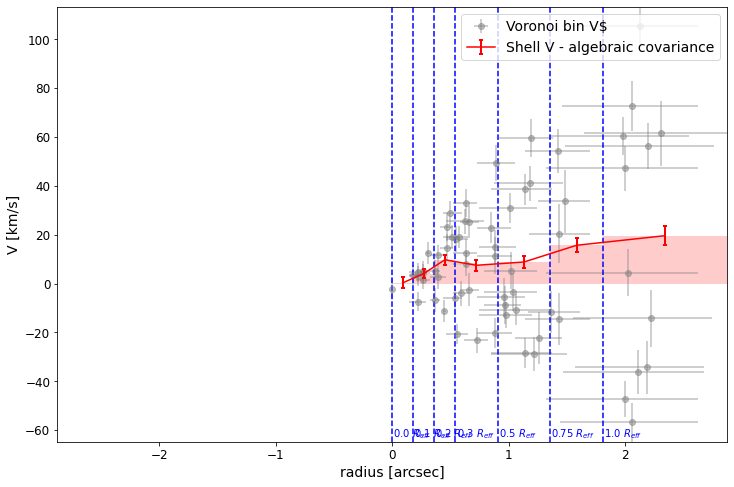

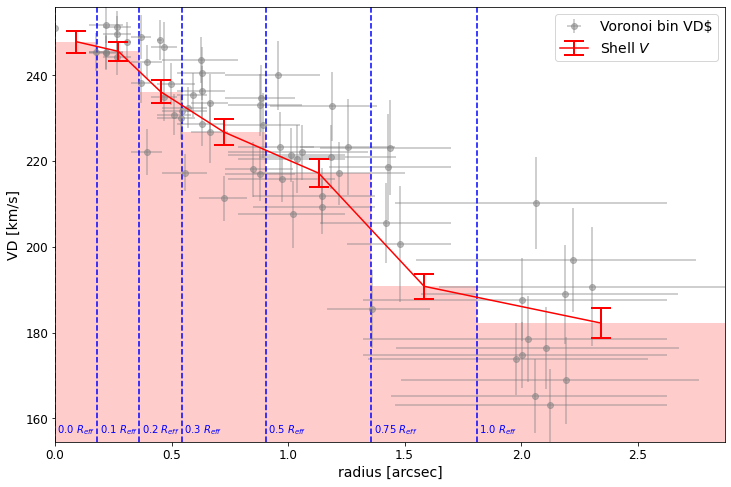

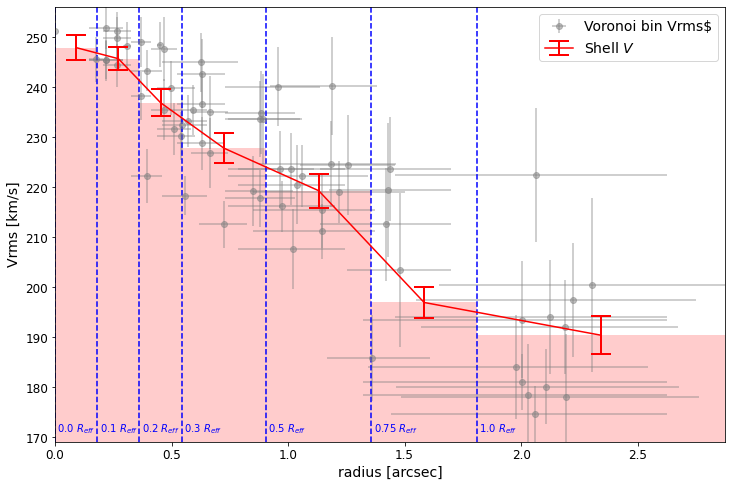


########################################################

Job's inished!


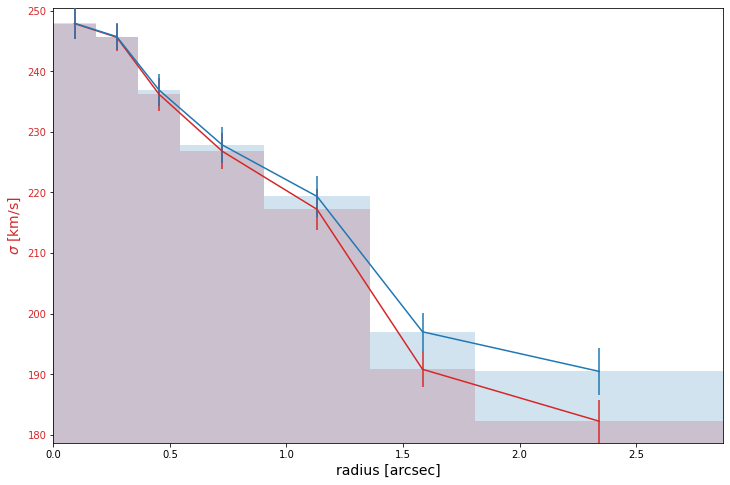

In [73]:
# try with one object

for obj_name in ['SDSSJ1250+0523']:#obj_names[:,0]:
    print(f'Rebinning {obj_name}... hold onto ya butts.')
    rebin_to_2D_shells (obj_name, shells, save=True)
    print()
    print('########################################################')
    print()
print("Job's inished!")

Rebinning SDSSJ0029-0055... hold onto ya butts.


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:112: RuntimeWarning: covariance is not positive-semidefinite.


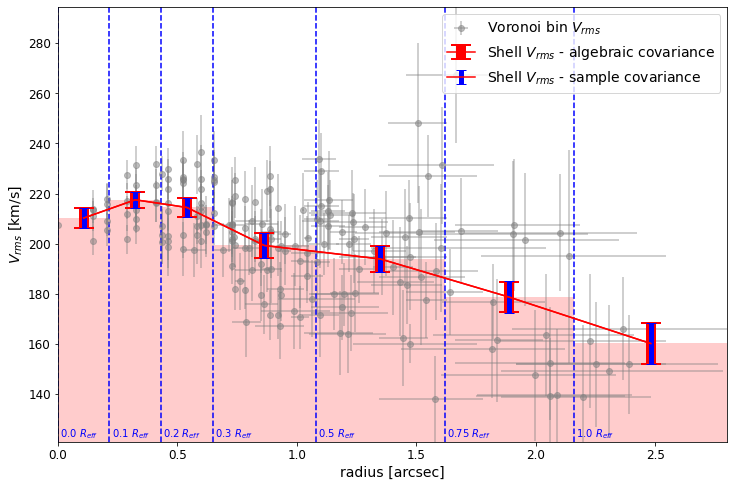


########################################################

Rebinning SDSSJ0037-0942... hold onto ya butts.


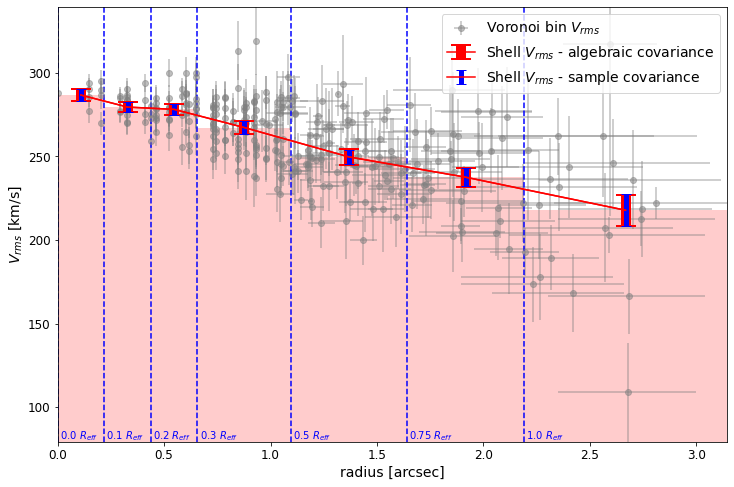


########################################################

Rebinning SDSSJ0330-0020... hold onto ya butts.


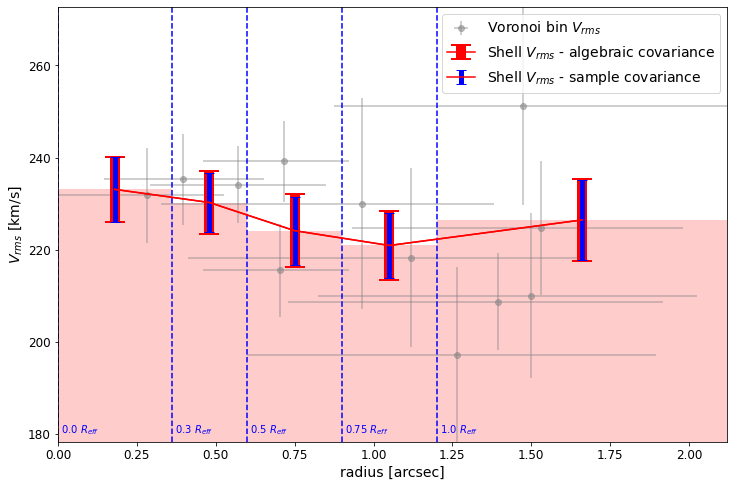


########################################################

Rebinning SDSSJ1112+0826... hold onto ya butts.


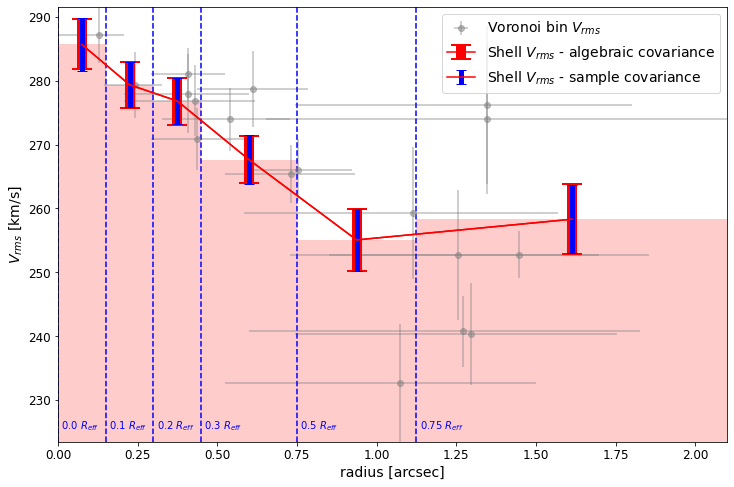


########################################################

Rebinning SDSSJ1204+0358... hold onto ya butts.


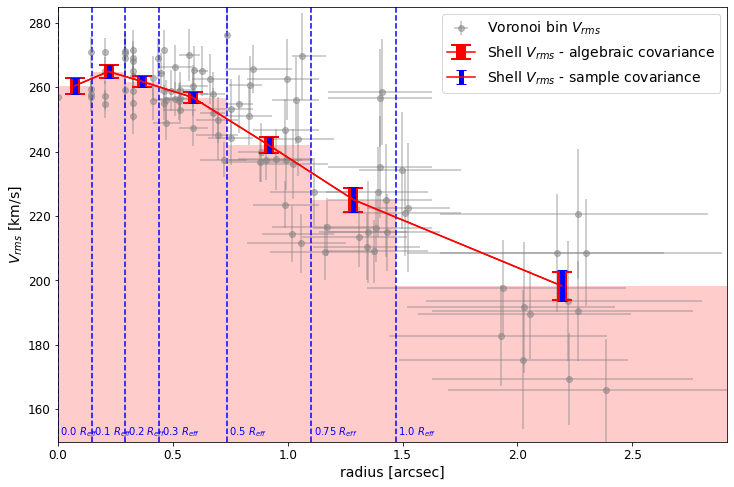


########################################################

Rebinning SDSSJ1250+0523... hold onto ya butts.


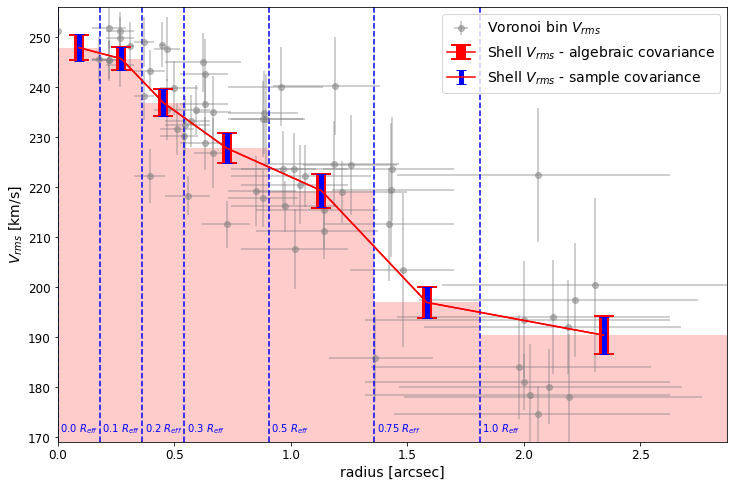


########################################################

Rebinning SDSSJ1306+0600... hold onto ya butts.


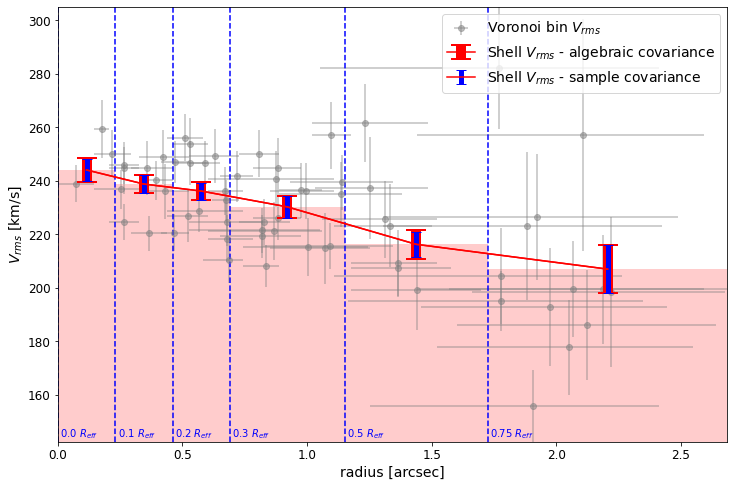


########################################################

Rebinning SDSSJ1402+6321... hold onto ya butts.


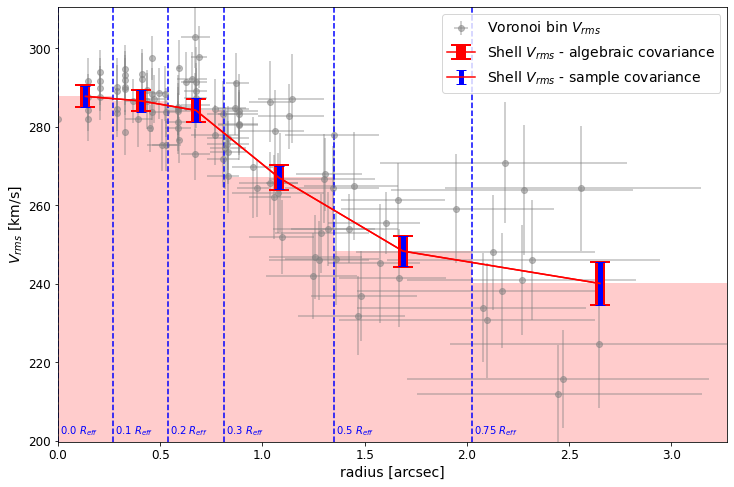


########################################################

Rebinning SDSSJ1531-0105... hold onto ya butts.


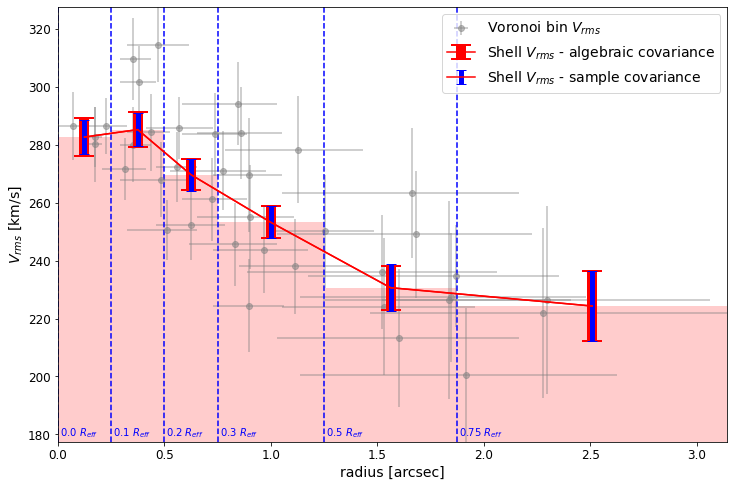


########################################################

Rebinning SDSSJ1538+5817... hold onto ya butts.


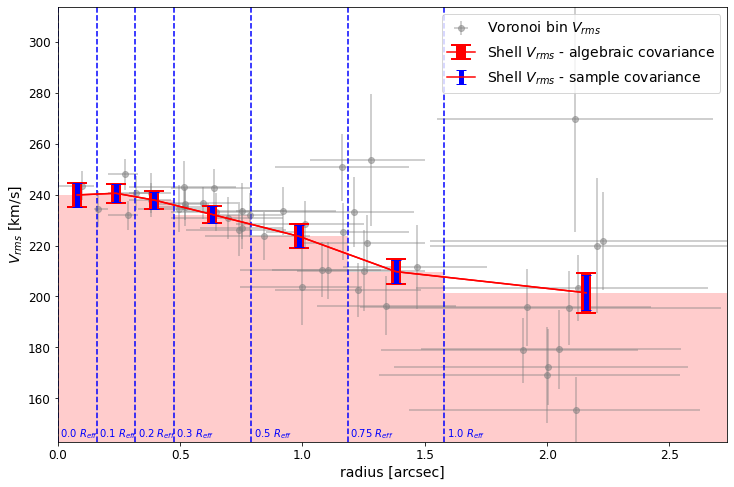


########################################################

Rebinning SDSSJ1621+3931... hold onto ya butts.


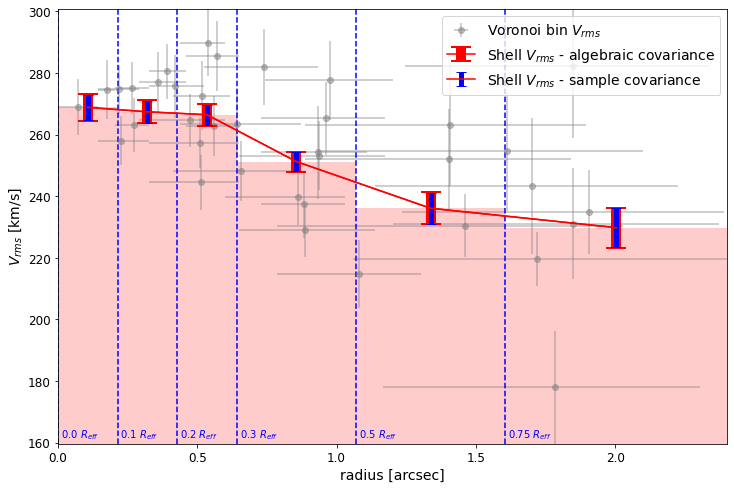


########################################################

Rebinning SDSSJ1627-0053... hold onto ya butts.


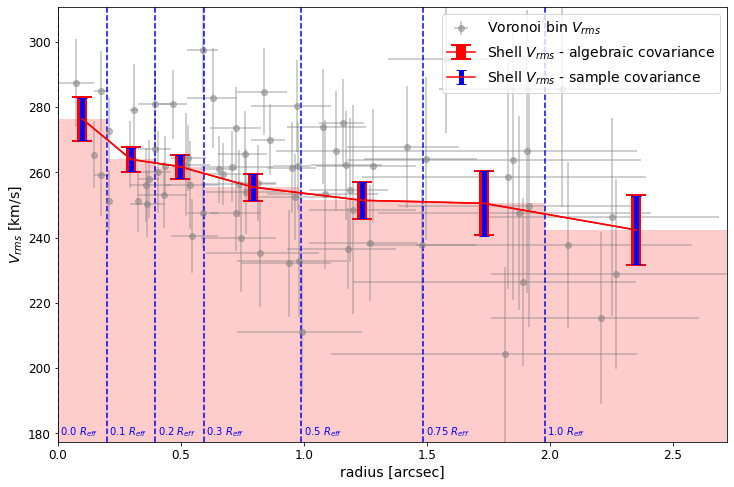


########################################################

Rebinning SDSSJ1630+4520... hold onto ya butts.


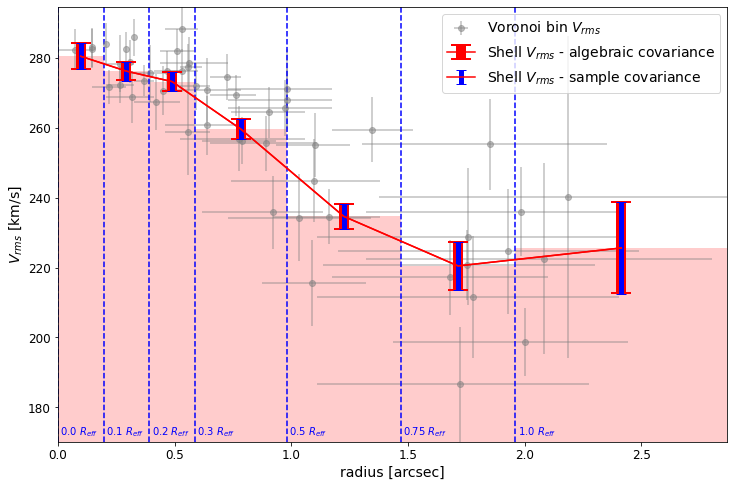


########################################################

Rebinning SDSSJ2303+1422... hold onto ya butts.


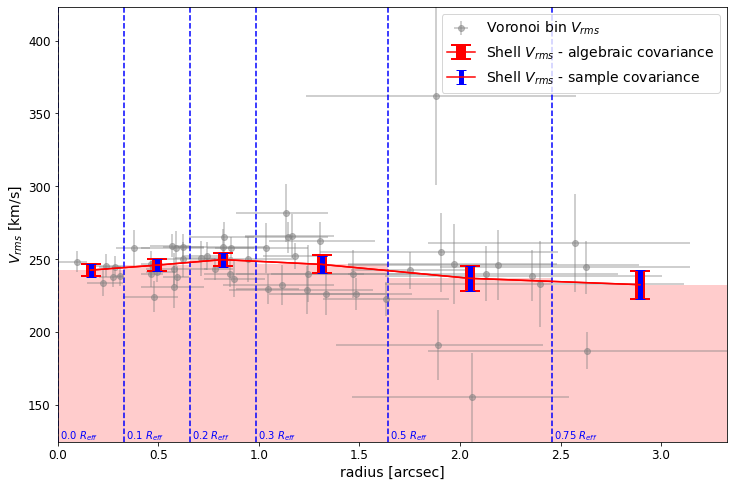


########################################################

Job's finished!


In [46]:
# try with all objects

for obj_name in obj_names:
    print(f'Rebinning {obj_name}... hold onto ya butts.')
    rebin_to_2D_shells (obj_name, shells, save=True)
    print()
    print('########################################################')
    print()
print("Job's finished!")

In [13]:
# try with one object

obj_name = 'SDSSJ0029-0055'
obj_abbr = obj_name[4:9] # e.g. J0029

# data directory
data_dir = '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/'
# object directory
dir = f'{data_dir}mosaics/{obj_name}/'

#KCWI mosaic datacube
name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'

# make new directory for outputs
output_dir = f'{dir}{obj_name}_1D_kinematics_milestone_2022/'
pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)

## import voronoi binning data
voronoi_binning_data = fits.getdata(dir +'voronoi_binning_' + name + '_data.fits')
voronoi_binning_data_input = np.genfromtxt(f'{dir}voronoi_2d_binning_{name}_input.txt',
                 delimiter='')
num_bins = len(voronoi_binning_data)
vorbin_pixels = np.genfromtxt(f'{dir}voronoi_2d_binning_{name}_output.txt',
                 delimiter='')
# sort the voronoi bin pixel data by bin
vorbin_pixels = vorbin_pixels[vorbin_pixels[:,2].argsort()]

# bring in cropped datacube and sum across wavelengths
file = f'{dir}KCWI_{obj_abbr}_icubes_mosaic_0.1457_crop.fits'
datacube = fits.open(file)[0].data
summed_datacube = np.nansum(datacube, axis=0)
normalized_summed_datacube = summed_datacube/np.sum(summed_datacube)

# get effective radius
# get reff
slacs_table = np.genfromtxt(f'{data_dir}slacs_tableA1.txt', delimiter='', dtype='U10')
slacs_table_name = obj_name[4:]
slacs_reffs = slacs_table[:,7].astype(float)
reff = slacs_reffs[slacs_table[:,0]==slacs_table_name]

# calculate radii of original Voronoi bins
Rmins, Rmaxs, Rmeans = calc_minmaxmean_R (vorbin_pixels, len(voronoi_binning_data))

# remove bins if there are no Rmeans within that bin
keep_shells = check_merge_shells (Rmeans, shells, reff)
shells = shells[keep_shells]

# sum each bin across all wavelengths
bin_luminosities = np.zeros(len(voronoi_binning_data))
for i in range(len(voronoi_binning_data)):
    lum = np.sum(voronoi_binning_data[i])
    bin_luminosities[i] = lum

# get velocity data 
Vrms=np.genfromtxt(f'{dir}{obj_name}_final_kinematics/{obj_name}_Vrms_binned.txt',
                 delimiter=',')
Vrms_cov = np.genfromtxt(f'{dir}{obj_name}_final_kinematics/{obj_name}_covariance_matrix_Vrms.txt',
                 delimiter=',')
dVrms = np.sqrt(np.diagonal(Vrms_cov)) # to have error bars

eigenvalues, _ = np.linalg.eig(Vrms_cov)
print(f' negative eigenvalues: {len(eigenvalues[eigenvalues < 0])}')
print(len(eigenvalues))

# calculate covariance matrix from samples
Vrms_samples = np.random.multivariate_normal(Vrms, Vrms_cov, 200, check_valid='raise') # draw samples for the covariance calculation

 negative eigenvalues: 4
193


ValueError: covariance is not positive-semidefinite.

In [14]:
np.array((Vrms_cov, Vrms_cov)).shape

(2, 193, 193)

In [15]:
# look at eigenvalues to see negatives (these indicate a pseudo-covariance matrix that can be smoothed to an approximate true one)

eigenvalues, _ = np.linalg.eig(Vrms_cov)
sum_eigenvalues = np.sum(eigenvalues)

# look at the percentage of the eigenvalues
eigenvalues[eigenvalues < 0]/sum_eigenvalues

array([-2.35328237e-04, -1.63848930e-04, -1.20076453e-04, -6.57158556e-05])

In [16]:
eigenvalues[eigenvalues < 0]

array([-9.7338777 , -6.77728037, -4.96672017, -2.71820377])

In [17]:
np.median(eigenvalues)

108.44474761628742

(array([181.,   9.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  -9.7338777 ,  596.53544247, 1202.80476265, 1809.07408282,
        2415.343403  , 3021.61272317, 3627.88204334, 4234.15136352,
        4840.42068369, 5446.69000387, 6052.95932404]),
 <BarContainer object of 10 artists>)

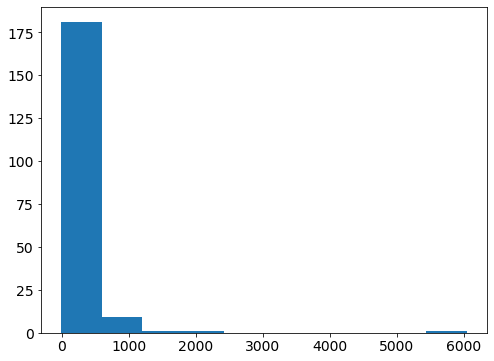

In [18]:
plt.hist(eigenvalues)

(array([1., 1., 1., 1., 0., 0., 1., 0., 1., 0.]),
 array([-10.,  -8.,  -6.,  -4.,  -2.,   0.,   2.,   4.,   6.,   8.,  10.]),
 <BarContainer object of 10 artists>)

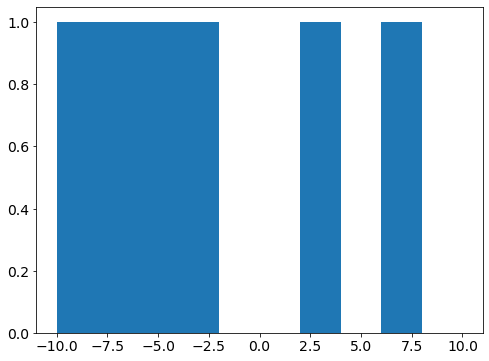

In [19]:
plt.hist(eigenvalues, range=(-10, 10))

(array([181.,   9.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([-0.00023533,  0.01442196,  0.02907926,  0.04373655,  0.05839384,
         0.07305113,  0.08770843,  0.10236572,  0.11702301,  0.1316803 ,
         0.14633759]),
 <BarContainer object of 10 artists>)

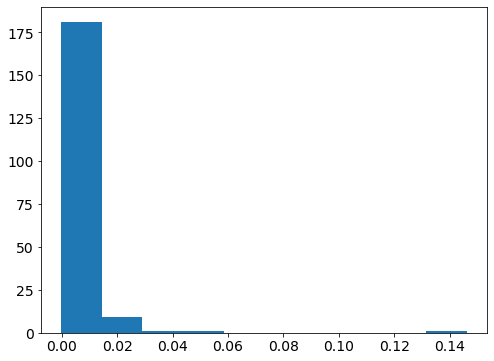

In [20]:
plt.hist(eigenvalues/sum_eigenvalues)

(array([124.,  41.,  12.,  11.,   3.,   1.,   0.,   0.,   0.,   1.]),
 array([0.00061243, 0.00490539, 0.00919835, 0.01349131, 0.01778427,
        0.02207723, 0.02637019, 0.03066314, 0.0349561 , 0.03924906,
        0.04354202]),
 <BarContainer object of 10 artists>)

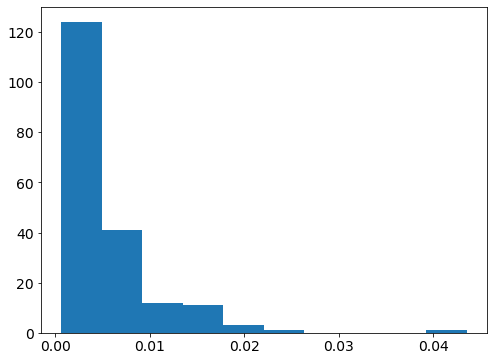

In [21]:
plt.hist(np.diagonal(Vrms_cov)/np.sum(np.diagonal(Vrms_cov)))

In [47]:
from statsmodels.stats.correlation_tools import cov_nearest

In [48]:
Vrms_cov_nearest = cov_nearest(Vrms_cov)

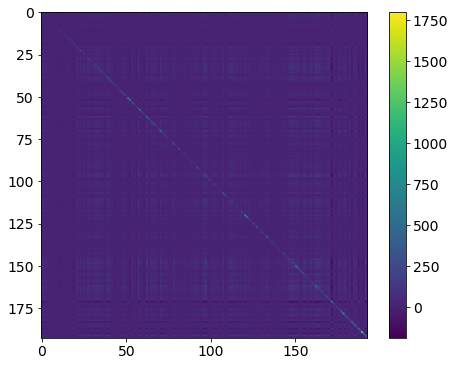

In [59]:
p = plt.imshow(Vrms_cov_nearest)
plt.colorbar(p)

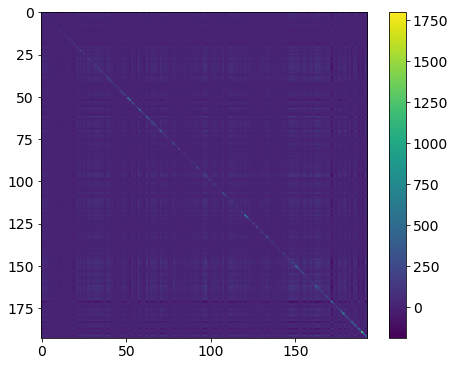

In [58]:
p = plt.imshow(Vrms_cov)
plt.colorbar(p)

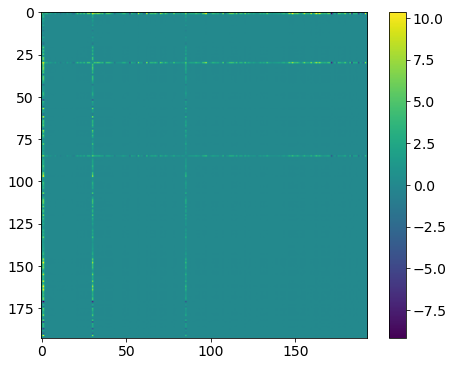

In [56]:
p = plt.imshow(Vrms_cov-Vrms_cov_nearest)
plt.colorbar(p)

In [23]:
inner_shell_edge = shells*reff
outer_shell_edge = np.append(shells[1:]*reff,np.max(Rmaxs))

In [24]:
outer_shell_edge

array([0.216     , 0.432     , 0.648     , 1.08      , 1.62      ,
       2.16      , 2.80259546])

In [25]:
inner_shell_edge

array([0.   , 0.216, 0.432, 0.648, 1.08 , 1.62 , 2.16 ])

In [ ]:
# Let's try doing it with samples

In [233]:
obj_name = obj_names[5]

In [234]:
obj_names[5]

'SDSSJ1250+0523'

In [106]:
# data directory
data_dir = '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/'
# object directory
dir = f'{data_dir}mosaics/{obj_name}/'

In [240]:
# try to draw samples from the covariance matrix
Vrms = np.genfromtxt(f'{dir}{obj_name}_final_kinematics/{obj_name}_Vrms_binned.txt',
                     delimiter=',')
Vrms_cov = np.genfromtxt(f'{dir}{obj_name}_final_kinematics/{obj_name}_covariance_matrix_Vrms.txt',
                     delimiter=',')

In [116]:
samples = np.random.multivariate_normal(Vrms, Vrms_cov, 200)
samples

array([[247.49708681, 244.74616627, 253.63661899, ..., 180.56670193,
        230.51715593, 201.80724511],
       [249.9980113 , 259.71943704, 252.75155688, ..., 195.05271698,
        227.48367732, 177.46494231],
       [248.83994297, 248.78755786, 254.92489672, ..., 188.98405298,
        228.4395438 , 186.38889073],
       ...,
       [248.87595872, 249.90487027, 244.73744067, ..., 203.40322504,
        223.68644333, 201.81287689],
       [255.05790691, 255.90516373, 255.45385356, ..., 198.47495279,
        230.408256  , 183.58100285],
       [252.62503333, 255.31283008, 254.53485715, ..., 173.329144  ,
        196.55630441, 190.93429472]])

In [242]:
save=False

In [243]:
obj_abbr = obj_name[4:9] # e.g. J0029

# data directory
data_dir = '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/'
# object directory
dir = f'{data_dir}mosaics/{obj_name}/'

#KCWI mosaic datacube
name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'

# make new directory for outputs
output_dir = f'{dir}{obj_name}_1D_kinematics_milestone_2022/'
pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)

## import voronoi binning data
voronoi_binning_data = fits.getdata(dir +'voronoi_binning_' + name + '_data.fits')
voronoi_binning_data_input = np.genfromtxt(f'{dir}voronoi_2d_binning_{name}_input.txt',
                 delimiter='')
num_bins = len(voronoi_binning_data)
vorbin_pixels = np.genfromtxt(f'{dir}voronoi_2d_binning_{name}_output.txt',
                 delimiter='')
# sort the voronoi bin pixel data by bin
vorbin_pixels = vorbin_pixels[vorbin_pixels[:,2].argsort()]

# bring in cropped datacube and sum across wavelengths
file = f'{dir}KCWI_{obj_abbr}_icubes_mosaic_0.1457_crop.fits'
datacube = fits.open(file)[0].data
summed_datacube = np.nansum(datacube, axis=0)
normalized_summed_datacube = summed_datacube/np.sum(summed_datacube)

# calculate radii of original Voronoi bins for plotting
Rmins, Rmaxs, Rmeans = calc_minmaxmean_R (vorbin_pixels, len(voronoi_binning_data))

# sum each bin across all wavelengths
bin_luminosities = np.zeros(len(voronoi_binning_data))
for i in range(len(voronoi_binning_data)):
    lum = np.sum(voronoi_binning_data[i])
    bin_luminosities[i] = lum

# get velocity data 
Vrms=np.genfromtxt(f'{dir}{obj_name}_final_kinematics/{obj_name}_Vrms_binned.txt',
                 delimiter=',')
Vrms_cov = np.genfromtxt(f'{dir}{obj_name}_final_kinematics/{obj_name}_covariance_matrix_Vrms.txt',
                 delimiter=',')
dVrms = np.sqrt(np.diagonal(Vrms_cov)) # to have error bars

# get effective radius
# get reff
slacs_table = np.genfromtxt(f'{data_dir}slacs_tableA1.txt', delimiter='', dtype='U10')
slacs_table_name = obj_name[4:]
slacs_reffs = slacs_table[:,7].astype(float)
reff = slacs_reffs[slacs_table[:,0]==slacs_table_name]

# calculate pixel luminosities
pixel_luminosities = np.zeros(len(vorbin_pixels))
for i in range(len(vorbin_pixels)):
    x = int(vorbin_pixels[i,0])
    y = int(vorbin_pixels[i,1])
    pixel_luminosity = summed_datacube[y,x]
    pixel_luminosities[i] = pixel_luminosity     

# calculate luminosity weights for each bin contribution to each shell
luminosity_weights = calc_luminosity_weights_in_shells(vorbin_pixels, num_bins, bin_luminosities, pixel_luminosities, shells, reff)
# sum over the weights for the normalization
sum_lum_weights = np.sum(luminosity_weights, axis=0)
normalized_lum_weights = luminosity_weights / sum_lum_weights

# calculate the luminosity-weighted mean Vrms for each shell
# multiply the transposed array by the Vrms to apply the weights to each V contribution
lum_weighted_Vrms = normalized_lum_weights.T*Vrms
# sum the weighted contributions
lum_weighted_mean_shell_Vrms = np.sum(lum_weighted_Vrms, axis=1)

# save array with pandas
if save == True:
    save_array = np.vstack((shells*reff,lum_weighted_mean_shell_Vrms)).T
    header_str = f'This is 1D rms velocity in km/s rebinned to radial shells of {obj_name} in arcsec calculated by taking luminosity weights from pixels'
    np.savetxt(f'{output_dir}{obj_name}_1D_Vrms.txt', lum_weighted_mean_shell_Vrms, header=header_str)

print()
print('Calculating covariance matrix')
print()
# calculate covariance matrix
# draw samples for the covariance calculation
Vrms_samples = np.random.multivariate_normal(Vrms, Vrms_cov, 200)


Calculating covariance matrix



In [245]:
# We have 200 samples of 65 bins
Vrms_samples.shape

(200, 65)

In [253]:
# for 7 shells we have 65 weights
lum_weighted_Vrms_samples[i] = normalized_lum_weights.T*Vrms_samples[0]

In [263]:
# rebin each of 200 samples with 65 bins each to 7 bins each

# multiply the transposed array by the Vrms to apply the weights to each V contribution
lum_weighted_Vrms_samples = np.zeros((len(Vrms_samples),len(shells),len(Vrms)))
lum_weighted_mean_shell_Vrms_samples = np.zeros((len(Vrms_samples),len(shells)))
for i in range(len(Vrms_samples)):
    lum_weighted_Vrms_sample = normalized_lum_weights.T*Vrms_samples[i]
    lum_weighted_Vrms_samples[i] = lum_weighted_Vrms_sample
    # sum the weighted contributions
    lum_weighted_mean_shell_Vrms_sample = np.sum(lum_weighted_Vrms_sample, axis=1)
    lum_weighted_mean_shell_Vrms_samples[i] = lum_weighted_mean_shell_Vrms_sample

#print(lum_weighted_mean_shell_Vrms_samples)

In [269]:
lum_weighted_mean_shell_Vrms_samples

array([[246.75075983, 243.54426093, 235.51962498, ..., 217.16763461,
        199.84464495, 193.22120964],
       [250.42681067, 249.08049351, 240.63697412, ..., 225.11650947,
        202.02681739, 193.79597586],
       [243.60004321, 246.17833519, 240.11569303, ..., 222.92939986,
        200.14379073, 193.00265704],
       ...,
       [251.26905109, 249.18559451, 240.37493265, ..., 224.12517883,
        201.94525532, 192.62126832],
       [249.54404902, 244.39317692, 234.9243739 , ..., 216.3124511 ,
        195.79836903, 192.4296219 ],
       [249.77213362, 246.79504634, 238.78185459, ..., 218.55570831,
        196.93585525, 190.96634534]])

In [271]:
# I don't know how this is calculated but it's wonky
np.cov(lum_weighted_mean_shell_Vrms_samples)

array([[436.20472813, 465.3246359 , 438.29657114, ..., 473.50631174,
        467.49838234, 487.73365326],
       [465.3246359 , 502.354452  , 473.59216034, ..., 508.84665571,
        496.33801338, 521.26272687],
       [438.29657114, 473.59216034, 449.93536817, ..., 479.97320821,
        467.17347432, 491.93896444],
       ...,
       [473.50631174, 508.84665571, 479.97320821, ..., 517.11704399,
        506.29038241, 530.11787004],
       [467.49838234, 496.33801338, 467.17347432, ..., 506.29038241,
        503.95125172, 522.9156324 ],
       [487.73365326, 521.26272687, 491.93896444, ..., 530.11787004,
        522.9156324 , 545.99753174]])

In [270]:
# here is the mean
lum_weighted_mean_shell_Vrms

array([247.94119477, 245.7291985 , 236.93984646, 227.85726752,
       219.33992362, 196.98958467, 190.45130928])

In [274]:
lum_weighted_mean_shell_Vrms_samples[:,0]

array([246.75075983, 250.42681067, 243.60004321, 244.26802084,
       247.04015738, 247.41358034, 248.18440593, 252.17110079,
       246.62897418, 251.29185139, 245.21782   , 246.60712317,
       242.32566871, 247.8515571 , 248.39982111, 248.42068569,
       249.03894701, 248.22364756, 248.55057202, 245.96021127,
       250.35530981, 250.33000027, 245.99554449, 244.43476539,
       246.03963866, 252.27350053, 247.47495989, 251.22636836,
       248.68672251, 248.76773066, 252.6127832 , 248.75840323,
       249.93983739, 245.44673055, 250.59180958, 247.46246791,
       248.61231973, 248.94579347, 242.0563548 , 250.32731528,
       246.3839529 , 246.24992274, 244.61134125, 245.44952352,
       247.87759294, 248.686425  , 249.70884247, 244.90564056,
       252.92739981, 245.28671003, 246.73383491, 246.58134409,
       247.60225155, 244.03635908, 249.87404766, 248.89590375,
       251.623686  , 248.72885933, 247.62678928, 247.24649393,
       247.86279382, 240.86156022, 250.23165494, 248.70

In [277]:
covariance_matrix_samples = np.zeros((len(shells),len(shells)))

# covariance of the shells
for i in range(len(shells)):
    for j in range(len(shells)):
        delta_S_i = (lum_weighted_mean_shell_Vrms_samples[:,i] - lum_weighted_mean_shell_Vrms[i])
        delta_S_j = (lum_weighted_mean_shell_Vrms_samples[:,j] - lum_weighted_mean_shell_Vrms[j])
        covariance_matrix_samples[i,j] = np.mean( delta_S_i * delta_S_j )
        
covariance_matrix_samples


array([[ 6.57597133,  4.41713024,  4.00862798,  4.38510541,  4.10872732,
         3.03407577,  2.67005374],
       [ 4.41713024,  5.22909461,  4.84719587,  4.86355355,  4.53920753,
         3.48114819,  2.71357323],
       [ 4.00862798,  4.84719587,  7.2038098 ,  6.88118568,  6.52603561,
         4.49855781,  2.96990651],
       [ 4.38510541,  4.86355355,  6.88118568,  8.88344816,  8.36865551,
         5.20116125,  3.57095572],
       [ 4.10872732,  4.53920753,  6.52603561,  8.36865551,  9.9896146 ,
         6.22680564,  3.47482405],
       [ 3.03407577,  3.48114819,  4.49855781,  5.20116125,  6.22680564,
         9.40905253,  7.53768229],
       [ 2.67005374,  2.71357323,  2.96990651,  3.57095572,  3.47482405,
         7.53768229, 13.26954461]])

In [280]:
# take covariance matrix from algebraic method
# calculate covariance matrix
covariance_matrix = np.zeros((len(shells), len(shells)))  
for n in range(len(shells)):
    for m in range(len(shells)):
        covariance_matrix[n,m] = estimate_covariance_between_shells(n, m, normalized_lum_weights.T, Vrms_cov, num_bins)

covariance_matrix

array([[ 6.42812127,  4.25744721,  4.27623948,  4.57362714,  4.65403729,
         3.04503307,  2.06882921],
       [ 4.25744721,  5.10810894,  4.7448291 ,  4.92298053,  4.99977781,
         3.33002469,  2.37216118],
       [ 4.27623948,  4.7448291 ,  7.21550764,  6.95202175,  6.89141139,
         4.37894365,  2.82815312],
       [ 4.57362714,  4.92298053,  6.95202175,  8.87265075,  8.89389881,
         5.0397579 ,  2.96884161],
       [ 4.65403729,  4.99977781,  6.89141139,  8.89389881, 11.32226973,
         6.58446652,  3.04439346],
       [ 3.04503307,  3.33002469,  4.37894365,  5.0397579 ,  6.58446652,
         9.63858867,  8.14252923],
       [ 2.06882921,  2.37216118,  2.82815312,  2.96884161,  3.04439346,
         8.14252923, 14.89346681]])

In [284]:
# what's the difference?

(covariance_matrix - covariance_matrix_samples) / covariance_matrix_samples * 100


array([[ -2.24833794,  -3.61508525,   6.67588772,   4.29913787,
         13.27199228,   0.3611411 , -22.51731933],
       [ -3.61508525,  -2.31370215,  -2.11187611,   1.22188406,
         10.14649088,  -4.34119713, -12.58164134],
       [  6.67588772,  -2.11187611,   0.16238407,   1.02941652,
          5.5987403 ,  -2.65894463,  -4.7729917 ],
       [  4.29913787,   1.22188406,   1.02941652,  -0.12154526,
          6.27631644,  -3.10321751, -16.86142735],
       [ 13.27199228,  10.14649088,   5.5987403 ,   6.27631644,
         13.34040593,   5.74389018, -12.38711899],
       [  0.3611411 ,  -4.34119713,  -2.65894463,  -3.10321751,
          5.74389018,   2.43952451,   8.0243093 ],
       [-22.51731933, -12.58164134,  -4.7729917 , -16.86142735,
        -12.38711899,   8.0243093 ,  12.23796485]])

In [290]:
# define function to rebin to shells

def rebin_to_2D_shells_samples (obj_name, save=False):
    
    obj_abbr = obj_name[4:9] # e.g. J0029
        
    # data directory
    data_dir = '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/'
    # object directory
    dir = f'{data_dir}mosaics/{obj_name}/'

    #KCWI mosaic datacube
    name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'
    
    # make new directory for outputs
    output_dir = f'{dir}{obj_name}_1D_kinematics_milestone_2022/'
    pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)
    
    ## import voronoi binning data
    voronoi_binning_data = fits.getdata(dir +'voronoi_binning_' + name + '_data.fits')
    voronoi_binning_data_input = np.genfromtxt(f'{dir}voronoi_2d_binning_{name}_input.txt',
                     delimiter='')
    num_bins = len(voronoi_binning_data)
    vorbin_pixels = np.genfromtxt(f'{dir}voronoi_2d_binning_{name}_output.txt',
                     delimiter='')
    # sort the voronoi bin pixel data by bin
    vorbin_pixels = vorbin_pixels[vorbin_pixels[:,2].argsort()]
    
    # bring in cropped datacube and sum across wavelengths
    file = f'{dir}KCWI_{obj_abbr}_icubes_mosaic_0.1457_crop.fits'
    datacube = fits.open(file)[0].data
    summed_datacube = np.nansum(datacube, axis=0)
    normalized_summed_datacube = summed_datacube/np.sum(summed_datacube)
    
    # calculate radii of original Voronoi bins for plotting
    Rmins, Rmaxs, Rmeans = calc_minmaxmean_R (vorbin_pixels, len(voronoi_binning_data))
    
    # sum each bin across all wavelengths
    bin_luminosities = np.zeros(len(voronoi_binning_data))
    for i in range(len(voronoi_binning_data)):
        lum = np.sum(voronoi_binning_data[i])
        bin_luminosities[i] = lum

    # get velocity data 
    Vrms=np.genfromtxt(f'{dir}{obj_name}_final_kinematics/{obj_name}_Vrms_binned.txt',
                     delimiter=',')
    Vrms_cov = np.genfromtxt(f'{dir}{obj_name}_final_kinematics/{obj_name}_covariance_matrix_Vrms.txt',
                     delimiter=',')
    dVrms = np.sqrt(np.diagonal(Vrms_cov)) # to have error bars
    
    # get effective radius
    # get reff
    slacs_table = np.genfromtxt(f'{data_dir}slacs_tableA1.txt', delimiter='', dtype='U10')
    slacs_table_name = obj_name[4:]
    slacs_reffs = slacs_table[:,7].astype(float)
    reff = slacs_reffs[slacs_table[:,0]==slacs_table_name]
    
    # calculate pixel luminosities
    pixel_luminosities = np.zeros(len(vorbin_pixels))
    for i in range(len(vorbin_pixels)):
        x = int(vorbin_pixels[i,0])
        y = int(vorbin_pixels[i,1])
        pixel_luminosity = summed_datacube[y,x]
        pixel_luminosities[i] = pixel_luminosity     
    
    # calculate luminosity weights for each bin contribution to each shell
    luminosity_weights = calc_luminosity_weights_in_shells(vorbin_pixels, num_bins, bin_luminosities, pixel_luminosities, shells, reff)
    # sum over the weights for the normalization
    sum_lum_weights = np.sum(luminosity_weights, axis=0)
    normalized_lum_weights = luminosity_weights / sum_lum_weights
    
    # calculate the luminosity-weighted mean Vrms for each shell
    # multiply the transposed array by the Vrms to apply the weights to each V contribution
    lum_weighted_Vrms = normalized_lum_weights.T*Vrms
    # sum the weighted contributions
    lum_weighted_mean_shell_Vrms = np.sum(lum_weighted_Vrms, axis=1)
    
    # save array with pandas
    if save == True:
        save_array = np.vstack((shells*reff,lum_weighted_mean_shell_Vrms)).T
        header_str = f'This is 1D rms velocity in km/s rebinned to radial shells of {obj_name} in arcsec calculated by taking luminosity weights from pixels'
        np.savetxt(f'{output_dir}{obj_name}_1D_Vrms.txt', lum_weighted_mean_shell_Vrms, header=header_str)
        
    print()
    print('Calculating covariance matrix')
    print()
    # calculate covariance matrix
    # draw samples for the covariance calculation
    Vrms_samples = np.random.multivariate_normal(Vrms, Vrms_cov, 200)
    
    #covariance_matrix = np.zeros((len(shells), len(shells)))  
    #for n in range(len(shells)):
    #    for m in range(len(shells)):
    #        covariance_matrix[n,m] = estimate_covariance_between_shells(n, m, normalized_lum_weights.T, Vrms_cov, num_bins)
    #print(covariance_matrix)
    #covariance_matrix = np.cov(lum_weighted_mean_shell_Vrms_samples)
    #dVrms_shell = np.sqrt(np.diagonal(covariance_matrix))
    
    # multiply the transposed array by the Vrms to apply the weights to each V contribution
    lum_weighted_Vrms_samples = np.zeros((len(Vrms_samples),len(shells),len(Vrms)))
    lum_weighted_mean_shell_Vrms_samples = np.zeros((len(Vrms_samples),len(shells)))
    for i in range(len(Vrms_samples)):
        lum_weighted_Vrms_sample = normalized_lum_weights.T*Vrms_samples[i]
        lum_weighted_Vrms_samples[i] = lum_weighted_Vrms_sample
        # sum the weighted contributions
        lum_weighted_mean_shell_Vrms_sample = np.sum(lum_weighted_Vrms_sample, axis=1)
        lum_weighted_mean_shell_Vrms_samples[i] = lum_weighted_mean_shell_Vrms_sample

    #print(lum_weighted_mean_shell_Vrms_samples)
        
    covariance_matrix_samples = np.zeros((len(shells),len(shells)))

    # covariance of the shells
    for i in range(len(shells)):
        for j in range(len(shells)):
            delta_S_i = (lum_weighted_mean_shell_Vrms_samples[:,i] - lum_weighted_mean_shell_Vrms[i])
            delta_S_j = (lum_weighted_mean_shell_Vrms_samples[:,j] - lum_weighted_mean_shell_Vrms[j])
            covariance_matrix_samples[i,j] = np.mean( delta_S_i * delta_S_j )
    dVrms_shell_samples = np.diagonal(covariance_matrix_samples)
    
    
    # calculate shell widths
    shell_widths = np.zeros(len(shells))
    for i in range(len(shell_widths)):
        if i < len(shell_widths)-1:
            shell_widths[i] = shells[i+1]*reff - shells[i]*reff
        else:
            shell_widths[i] = np.max(Rmaxs) - shells[i]*reff # take max radius from voronoi bins
    
    # plot rms velocities and overplot the original bins
    # axis lengths
    xmax = np.max(Rmaxs)
    ymin = np.min(Vrms) - dVrms[np.argmin(Vrms)]
    ymax = np.max(Vrms) + dVrms[np.argmax(Vrms)]
    # set up figure
    plt.figure(figsize=(12,8))
    plt.xlim(0, xmax)
    plt.ylim(ymin, ymax)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('radius [arcsec]', fontsize=14)
    plt.ylabel(r'$V_{rms}$ [km/s]', fontsize=14)
    # plot the voronoi bin velocities
    plt.errorbar(Rmeans, Vrms, 
                 xerr=(Rmeans-Rmins,Rmaxs-Rmeans),
                 yerr=dVrms,
                 c='grey',
                 marker='o', 
                 linestyle='None',
                label=r'Voronoi bin $V_{rms}$',
                alpha=0.5)
    # plot the binned Vrms as bars
    plt.bar(shells*reff, lum_weighted_mean_shell_Vrms, width=shell_widths, 
            align='edge', color='r', alpha=0.2)
    # plot curve from center of each shell
    plt.errorbar(shells*reff+shell_widths/2, lum_weighted_mean_shell_Vrms, 
                 yerr=dVrms_shell_samples,
                 c='r', 
                 label=r'luminosity-weighted shell $V_{rms}$', 
                 zorder=100)
    for bin in shells:
        plt.axvline(bin*reff, c='b', linestyle='--')
        bin_text = str(bin) + r' $R_{eff}$'
        plt.annotate(bin_text, (bin*reff+0.01, ymin+2), color='b', fontsize=10 )
    plt.legend(fontsize=14, loc='upper right')
    if save == True:
        plt.savefig(f'{output_dir}{obj_name}_1D_Vrms_plot.png')
        plt.savefig(f'{output_dir}{obj_name}_1D_Vrms_plot.png')
    plt.show()



Rebinning SDSSJ1250+0523... hold onto ya butts.

Calculating covariance matrix



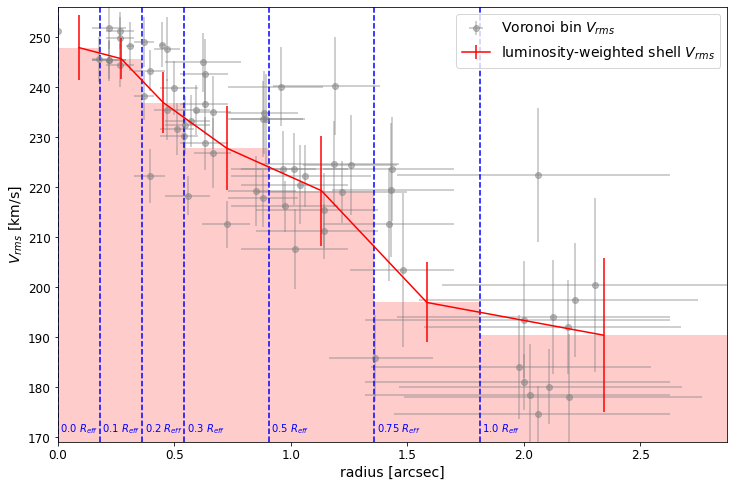


########################################################

Job's inished!


In [291]:
# run through all objects

obj_name = obj_names[5]

#for obj_name in ['SDSSJ0029-0055']:#obj_names[:,0]:
print(f'Rebinning {obj_name}... hold onto ya butts.')
rebin_to_2D_shells_samples (obj_name)
print()
print('########################################################')
print()
print("Job's inished!")

In [ ]:
obj_abbr = obj_name[4:9] # e.g. J0029

# data directory
data_dir = '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/'
# object directory
dir = f'{data_dir}mosaics/{obj_name}/'

#KCWI mosaic datacube
name = f'KCWI_{obj_abbr}_icubes_mosaic_0.1457'

save_dir = f'{dir}{obj_name}_systematics/'

In [221]:
## import voronoi binning data
voronoi_binning_data = fits.getdata(dir +'voronoi_binning_' + name + '_data.fits')
voronoi_binning_data_input = np.genfromtxt(f'{dir}voronoi_2d_binning_{name}_input.txt',
                 delimiter='')
vorbin_pixels = np.genfromtxt(f'{dir}voronoi_2d_binning_{name}_output.txt',
                 delimiter='')

In [223]:
voronoi_binning_data_input.shape

(1025, 4)

In [224]:
vorbin_pixels.shape

(1025, 3)

In [220]:
voronoi_binning_data.shape

(65, 5215)

In [4]:
# sort the voronoi bin pixel data by bin
vorbin_pixels = vorbin_pixels[vorbin_pixels[:,2].argsort()]

In [5]:
def calc_minmaxmean_R (bin_arrays, num_bins):
    
    bin_R_mins = np.zeros(num_bins)
    bin_R_maxs = np.zeros(num_bins)
    bin_R_means = np.zeros(num_bins)
    
    for i in range(num_bins):
        bin_pixels = bin_arrays[bin_arrays[:,2]==i]
        bin_xx = bin_pixels[:,0] - 21 # subtract 21 pixels, center don't know which is x and which is y, but doesn't matter for R
        bin_yy = bin_pixels[:,1] - 21
        bin_R = np.zeros(len(bin_pixels))
        for j in range(len(bin_pixels)):
            bin_R[j] = np.sqrt(bin_xx[j]**2 + bin_yy[j]**2)
        bin_R_mins[i] = np.min(bin_R)*0.1457
        bin_R_maxs[i] = np.max(bin_R)*0.1457
        bin_R_means[i] = np.mean(bin_R)*0.1457
        
    return bin_R_mins, bin_R_maxs, bin_R_means
            

In [6]:
Rmins, Rmaxs, Rmeans = calc_minmaxmean_R (vorbin_pixels, len(voronoi_binning_data))


<ErrorbarContainer object of 3 artists>

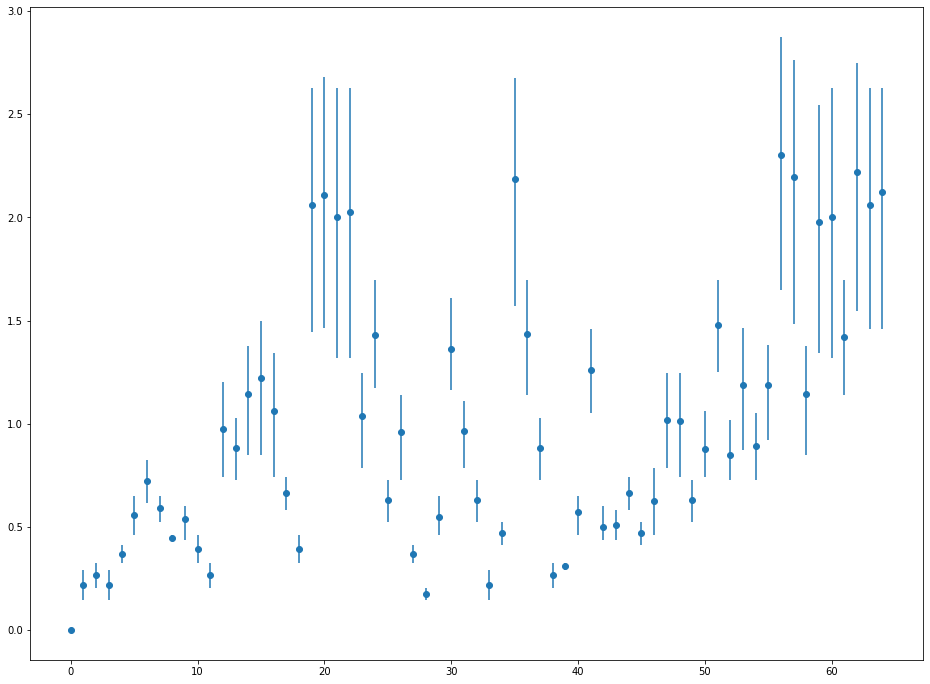

In [7]:
plt.figure(figsize=(16,12))
plt.errorbar(range(len(Rmeans)),Rmeans, yerr=(Rmeans-Rmins,Rmaxs-Rmeans),marker='o', linestyle='None')

In [8]:
# get velocity and bin data 
Vrms=np.genfromtxt(f'{dir}{obj_name}_final_kinematics/{obj_name}_Vrms_binned.txt',
             delimiter=',')
Vrms_cov = np.genfromtxt(f'{dir}{obj_name}_final_kinematics/{obj_name}_covariance_matrix_Vrms.txt',
                 delimiter=',')
dVrms = np.sqrt(np.diagonal(Vrms_cov)) # to have error bars


Text(0, 0.5, '$V_{rms}$ (km/s)')

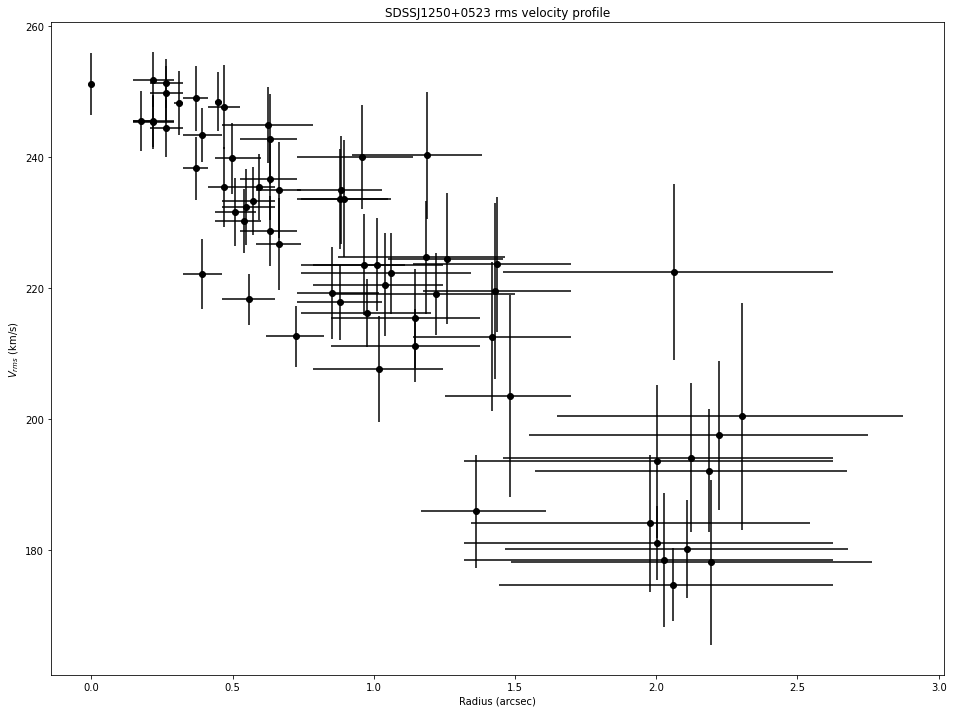

In [9]:
plt.figure(figsize=(16,12))
plt.errorbar(Rmeans, Vrms, 
             xerr=(Rmeans-Rmins,Rmaxs-Rmeans),
             yerr=dVrms,
             c='k',
             marker='o', 
             linestyle='None')
plt.title(f'{obj_name} rms velocity profile')
plt.xlabel('Radius (arcsec)')
plt.ylabel(r'$V_{rms}$ (km/s)')


# Now bin them radially to 6-10 bins. 
Need to rebin the velocities by radius (6-10 bins)

New bin values will be flux averaged of contributing bins

New bins will not be equal width (radius)

For outer-most new bin containing all the dregs: To get inner/outer bin boundary, average the inner/outer boundaries of the individual bins; maybe outside reff?

In [11]:
# get effective radius
# get reff
slacs_table = np.genfromtxt(f'{data_dir}slacs_tableA1.txt', delimiter='', dtype='U10')
slacs_table_name = obj_name[4:]
slacs_reffs = slacs_table[:,7].astype(float)
reff = slacs_reffs[slacs_table[:,0]==slacs_table_name]

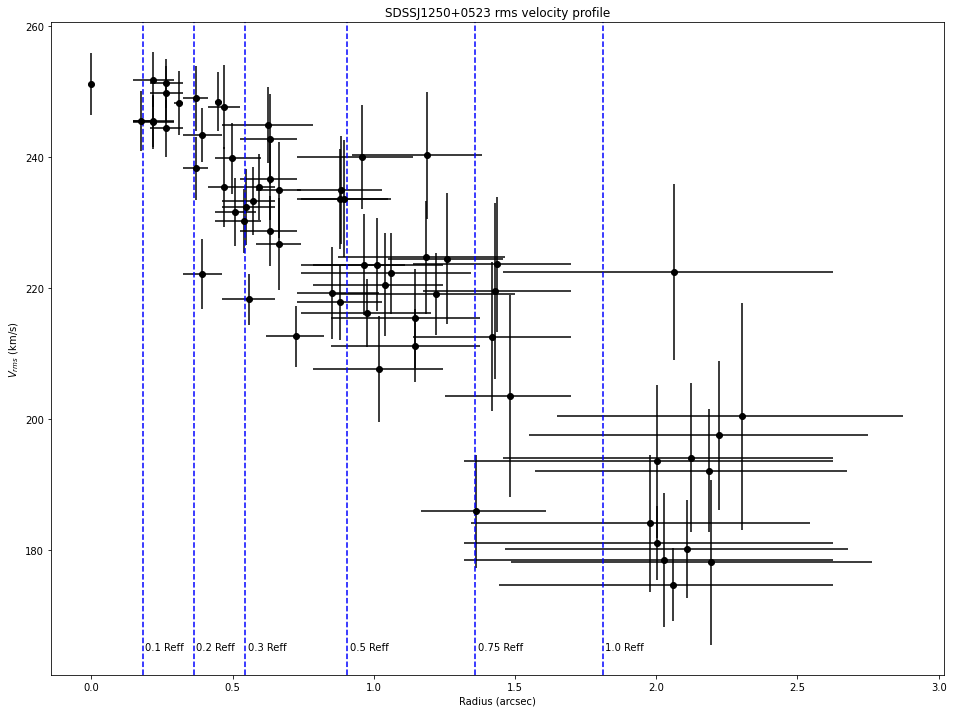

In [12]:
# plot rms velocities
plt.figure(figsize=(16,12))
plt.errorbar(Rmeans, Vrms, 
             xerr=(Rmeans-Rmins,Rmaxs-Rmeans),
             yerr=dVrms,
             c='k',
             marker='o', 
             linestyle='None')
plt.title(f'{obj_name} rms velocity profile')
plt.xlabel('Radius (arcsec)')
plt.ylabel(r'$V_{rms}$ (km/s)')

# plot radial bin boundaries as fraction of reff
radial_bins = [0.1,0.2,0.3,0.5,0.75,1.0]
for bin in radial_bins:
    plt.axvline(bin*reff, c='b', linestyle='--')
    plt.annotate(f'{bin} Reff', (bin*reff+0.01, np.min(Vrms)-10) )


In [13]:
colors = ['cyan','b','g','pink','orange','purple','red']
hatches = ['/', '\\','o','-', 'x', '*', 'O', '+']

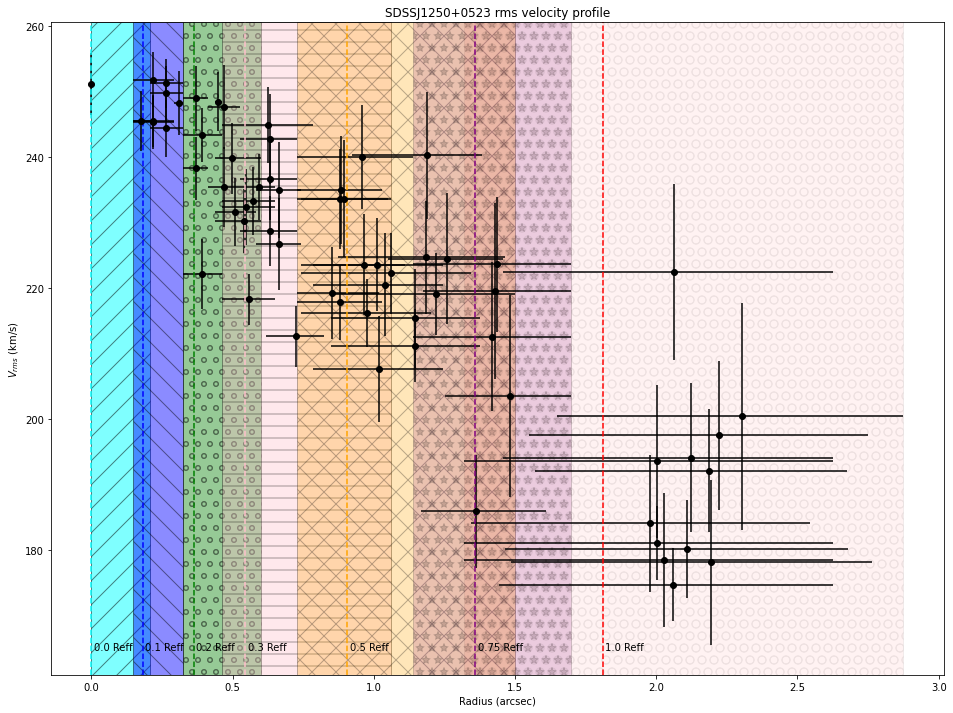

In [14]:
# see what outer bin would look like with lower and upper boundaries

outer_bin = Rmeans[Rmeans > reff]
outer_bin_low = np.mean(Rmins[Rmeans > reff])
outer_bin_hi = np.mean(Rmaxs[Rmeans > reff])

# plot rms velocities
plt.figure(figsize=(16,12))
plt.errorbar(Rmeans, Vrms, 
             xerr=(Rmeans-Rmins,Rmaxs-Rmeans),
             yerr=dVrms,
             c='k',
             marker='o', 
             linestyle='None')
plt.title(f'{obj_name} rms velocity profile')
plt.xlabel('Radius (arcsec)')
plt.ylabel(r'$V_{rms}$ (km/s)')

# plot radial bin boundaries as fractions of reff
radial_bins = [0.0,0.1,0.2,0.3,0.5,0.75,1.0]
for i in range(len(radial_bins)):
    bin = radial_bins[i]
    if i != len(radial_bins)-1:
        next_bin = radial_bins[i+1]
        in_bin = (Rmeans >= bin*reff) & (Rmeans < next_bin*reff)
        #inner_bin = bin*reff
        #outer_bin = next_bin*reff
    else:
        in_bin = Rmeans > bin*reff
        
    inner_bin = np.min(Rmins[in_bin])
    outer_bin = np.max(Rmaxs[in_bin])
    
    bin_data = Rmeans[in_bin]

    plt.axvline(bin*reff, c=colors[i], linestyle='--')
    plt.annotate(f'{bin} Reff', (bin*reff+0.01, np.min(Vrms)-10) )
    plt.axvspan(inner_bin, outer_bin, alpha=(0.5*(1-0.9*bin)), facecolor=colors[i], edgecolor='k', hatch=hatches[i])


In [84]:
# What if instead, I take fixed bins and take fractional contributions of each datapoint to the amount that it overlaps with the bin.

Rs = np.vstack((Rmeans,Rmins,Rmaxs)).T

numbins = 7

in_bins = np.zeros((numbins,len(Rs)),dtype=bool)

# plot radial bin boundaries as fractions of reff
radial_bins = [0.0,0.1,0.2,0.3,0.5,0.75,1.0]
for i in range(numbins):
    bin = radial_bins[i]
    if i != len(radial_bins)-1:
        next_bin = radial_bins[i+1]
        in_bin = in_bins[i]
        for j in range(len(Rmeans)):
            #print(Rs[j], bin, next_bin)
            j_in_bin = ( any(R >= bin*reff for R in Rs[j] ) & ( any(R < next_bin*reff for R in Rs[j])) )
            #print(j_in_bin)
            in_bin[j] = j_in_bin
        #inner_bin = bin*reff
        #outer_bin = next_bin*reff
    else:
        in_bins[i] = Rmeans > bin*reff




In [85]:
in_bins

array([[ True,  True, False,  True, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False,  True, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False],
       [False,  True,  True,  True,  True, False, False, False, False,
        False,  True,  True, False, False, False, False, False, False,
         True, False, False, False, False, False, False, False, False,
         True,  True, False, False, False, False,  True, False, False,
        False, False,  True,  True, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, Fals

In [86]:
# in bins is now the mask for selecting each radial bin...
R_bin_0 = np.array(([Rmeans[in_bins[0]],Rmins[in_bins[0]],Rmaxs[in_bins[0]]])).T
R_bin_0

array([[0.        , 0.        , 0.        ],
       [0.21855   , 0.1457    , 0.2914    ],
       [0.21855   , 0.1457    , 0.2914    ],
       [0.17587546, 0.1457    , 0.20605092],
       [0.21855   , 0.1457    , 0.2914    ]])

In [87]:
# to determine the fraction of each j_bin that lies within the radial bin 0, take [min(upper_bin - Rmax) - max(lower_bin - Rmin)]/[R_max-Rmin]

for Rj in R_bin_0:
    Rjmax = Rj[2]
    Rjmin = Rj[1]
    Rbin0 = radial_bins[0]*reff
    Rbin1 = radial_bins[1]*reff
    len_in = min(Rbin1,Rjmax) - max(Rbin0,Rjmin)
    len_jbin = Rjmax-Rjmin
    frac_in_bin = len_in/len_jbin
    if all(Rj == 0):
        frac_in_bin = 1
    print(frac_in_bin)

1
[0.24227865]
[0.24227865]
[0.58491241]
[0.24227865]


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [88]:
# jbin will refer to the jth spatial bin, rbin will refer to the ith radial bin

In [89]:
# for each group of bins

Vrms_bins = np.zeros(numbins)
bin_centers = np.zeros(numbins)


for i in range(numbins):
    # create array of Rmean, Rmin, Rmax for each jbin in the rbin
    Rs_in_bin = np.array(([Rmeans[in_bins[i]],Rmins[in_bins[i]],Rmaxs[in_bins[i]]])).T
    print(Rs_in_bin.shape)
    # create array to fill with fractions
    fracs_in_bin = np.zeros(len(Rs_in_bin))
    if i < numbins - 1:
        # get bin boundaries and centers
        Rbin0 = radial_bins[i]*reff
        Rbin1 = radial_bins[i+1]*reff
    else:
        Rbin0 = radial_bins[i]*reff
        Rbin1 = 10 * reff
        # iterate through each jbin, calculate the fraction of that jbin within the rbin
    for j in range(len(Rs_in_bin)):
        Rj = Rs_in_bin[j]
        Rjmax = Rj[2]
        Rjmin = Rj[1]
        len_in = min(Rbin1,Rjmax) - max(Rbin0,Rjmin)
        len_jbin = Rjmax-Rjmin
        frac_in_bin = len_in/len_jbin
        if all(Rj == 0):
            frac_in_bin = 1
        fracs_in_bin[j] = frac_in_bin
    # fracs_in_bin are one of the weights for the average Vrms in the bin
    Vrms_bin = np.sum(Vrms[in_bins[i]]*fracs_in_bin)/np.sum(fracs_in_bin)
    print(Vrms_bin)
    Vrms_bins[i] = Vrms_bin



(5, 3)
248.63454969950072
(12, 3)
246.5099460364726
(18, 3)
237.61201685543625
(30, 3)
229.40231176984054
(27, 3)
221.09155704660964
(23, 3)
201.17169985578613
(12, 3)
190.18050200905662


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


190.18050200905662


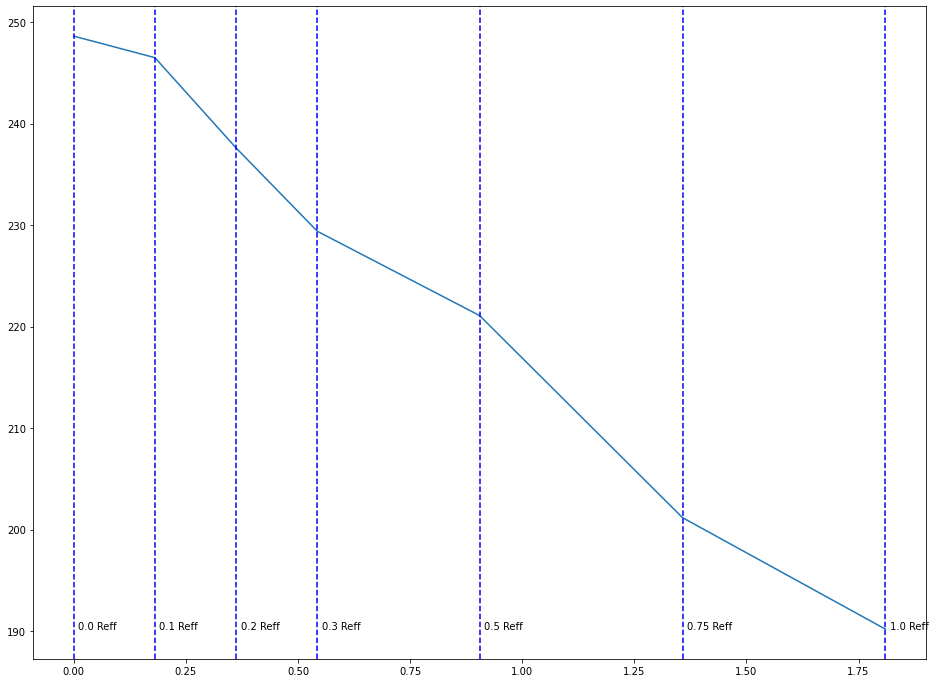

In [196]:
# plot rms velocities
plt.figure(figsize=(16,12))
plt.plot(radial_bins*reff, Vrms_bins)
#plt.axvline(bin*reff, c=colors[i], linestyle='--')
for bin in radial_bins:
    plt.axvline(bin*reff, c='b', linestyle='--')
    plt.annotate(f'{bin} Reff', (bin*reff+0.01, np.min(Vrms_bins)) )
print( np.min(Vrms_bins))

I'm pondering the best way to collapse the 2D bins into new 1D radial bins (concentric shells). I have been defining the radial extent of the bin by the innermost and outermost pixel radii, but that ignores the 2D shape of the bin (I'll get back to that). Say I want to bin it into fractions of r_eff...

Where each datapoint shows the mean radius of the 2D bins, and the "x error" is showing the radial extent of the 2D bins. I want to take the fraction of each 2D bin within each shell as a weighted contribution to the velocity within that shell bin. Would it make more sense to assign fractions of each 2D bin to their contribution to the 1D shell bins? It would be something like (of pixels within 2D bin #N, 0.34 is in shell bin 1, 0.46 is in shell bin 2, and 0.2 is in shell bin 3). Then the weighted contribution of 2D bin #N to the mean Vrms of shell bin 2 is Vrms of 2D bin #N times 0.46. It's a fractional volume instead of a fractional radius.

Problem is... the uncertainty is on the whole bin's measurement. This is becoming very complicated. Maybe it should be treated as a singular measurement at the mean radius of the 2D bin instead of an extent. The uncertainty of the spatial aspect is confusing to me.

In [ ]:
# I'm going to call the 1D bins "shells" from here out

In [91]:
reff

array([1.81])

In [92]:
shells = radial_bins

In [185]:
def calc_fractions_in_shells (bin_arrays, num_bins, shells):
    
    # create array with each bin and len num_bins
    shell_fractions = np.zeros((num_bins, len(shells)))
    
    for i in range(num_bins):
        # pixels in this bin, take x and y coordinates
        bin_pixels = bin_arrays[bin_arrays[:,2]==i]
        bin_xx = bin_pixels[:,0] - 21 # subtract 21 pixels, center don't know which is x and which is y, but doesn't matter for R
        bin_yy = bin_pixels[:,1] - 21
        # calculate radius of each pixel in the bin
        bin_R = np.zeros(len(bin_pixels))
        for j in range(len(bin_pixels)):
            bin_R[j] = np.sqrt(bin_xx[j]**2 + bin_yy[j]**2)*0.1457 # arcsec
        # calculate fraction of these pixels in each shell
        for k in range(len(shells)):
            inner_shell = shells[k]
            if k == len(shells) - 1:
                outer_shell = 10 # everything extending to the farthest pixel
            else:
                outer_shell = shells[k+1]
            in_shell = (bin_R >= inner_shell*reff) & (bin_R <= outer_shell*reff)
            fraction_in_shell = len(bin_R[in_shell])/len(bin_R)
            shell_fractions[i,k] = fraction_in_shell
        
    return shell_fractions

In [186]:
shell_fractions = calc_fractions_in_shells (vorbin_pixels, len(voronoi_binning_data), shells)
# last shell
shell_fractions[:,-1]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.72727273,
       0.76785714, 0.67213115, 0.6984127 , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.85185185, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.92647059, 0.8125    , 0.        , 0.65306122,
       0.66071429, 0.        , 0.86440678, 0.73684211, 0.80357143])

In [192]:
weights = shell_fractions.T
sum_weights = np.sum(shell_fractions, axis=0)
weighted_Vrms = weights*Vrms
weighted_Vrms
weighted_mean_shell_Vrms = np.sum(weighted_Vrms, axis=1) / sum_weights
weighted_mean_shell_Vrms

array([248.44960453, 245.5444604 , 237.78697643, 229.08069859,
       220.99182566, 203.17258704, 190.14418637])

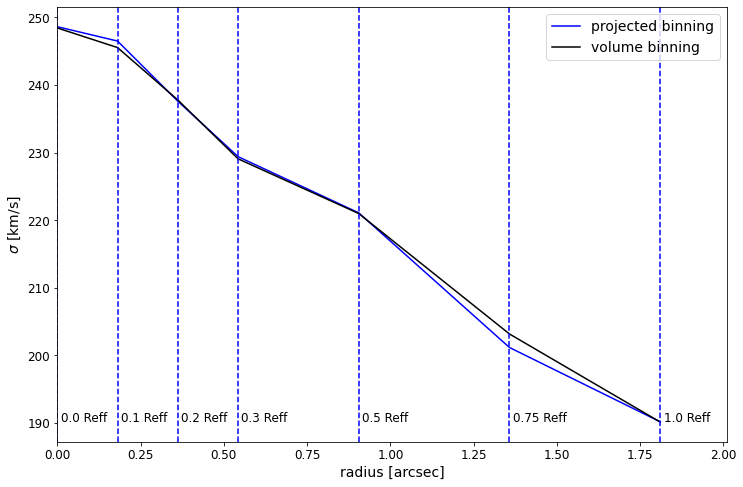

In [215]:
# plot rms velocities
plt.figure(figsize=(12,8))
plt.xlim(0, reff+0.2)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('radius [arcsec]', fontsize=14)
plt.ylabel(r'$\sigma$ [km/s]', fontsize=14)
plt.plot(radial_bins*reff, Vrms_bins, c='b', label='projected binning')
plt.plot(radial_bins*reff, weighted_mean_shell_Vrms, c='k', label='volume binning')
plt.legend(fontsize=14)
for bin in radial_bins:
    plt.axvline(bin*reff, c='b', linestyle='--')
    plt.annotate(f'{bin} Reff', (bin*reff+0.01, np.min(Vrms_bins)), fontsize=12 )


In [190]:
weight_mean_shell

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.72727273,
       0.76785714, 0.67213115, 0.6984127 , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.85185185, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.92647059, 0.8125    , 0.        , 0.65306122,
       0.66071429, 0.        , 0.86440678, 0.73684211, 0.80357143])

# Let's weight it by luminosity instead of equal pixel areas

In [217]:
# sum each bin across all wavelengths

bin_luminosities = np.zeros(len(voronoi_binning_data))

for i in range(len(voronoi_binning_data)):
    lum = np.sum(voronoi_binning_data[i])
    bin_luminosities[i] = lum
    
bin_luminosities

array([ 91.86698995, 159.76162749, 149.21711566, 152.64773311,
       117.12008515, 186.01146459, 140.18211714, 123.99207858,
       129.53223056, 153.01574078, 128.21451638, 154.08944731,
       199.97517837, 184.52638027, 255.55643944, 263.01949355,
       287.25069533, 145.00834167, 130.28199103, 267.36509835,
       252.71345887, 361.87161546, 317.21407373, 213.11478052,
       199.84448482, 168.18957689, 231.58965025, 126.9377418 ,
       169.91783107, 140.24111742, 234.48451523, 211.5688669 ,
       199.60830379, 161.75847966, 128.05024103, 289.16746159,
       251.40078554, 178.61601917, 153.68718009, 143.62473043,
       143.51551642, 165.37289544, 156.74607681, 110.8703855 ,
       156.11217044, 123.29438739, 175.11898168, 231.02447894,
       273.52344619, 179.2136836 , 141.26012223, 206.21808063,
       154.28487262, 316.36927328, 153.71613154, 218.37174943,
       337.44213068, 346.0114141 , 263.44611315, 308.16364712,
       334.67274136, 178.43385791, 330.71077672, 287.37

In [242]:
np.sum(voronoi_binning_data[0])

91.8669899486143

In [248]:
pixel_snr = voronoi_binning_data_input[:,2]
pixel_snr.shape

(1025,)

In [249]:
np.sum(pixel_snr[bin_arrays[:,2]==0])

17.202228

In [259]:
# bring in cropped datacube and sum across wavelengths
file = f'{dir}KCWI_{obj_abbr}_icubes_mosaic_0.1457_crop.fits'
datacube = fits.open(file)[0].data

summed_datacube = np.nansum(datacube, axis=0)

normalized_summed_datacube = summed_datacube/np.sum(summed_datacube)



In [271]:
summed_datacube[2,4]

-1.0343549305231272

In [272]:
pixel_luminosities = np.zeros(len(bin_arrays))
for i in range(len(bin_arrays)):
    x = int(bin_arrays[i,0])
    y = int(bin_arrays[i,1])
    pixel_luminosity = summed_datacube[y,x]
    pixel_luminosities[i] = pixel_luminosity
pixel_luminosities

array([1.80471997, 2.1080026 , 2.06173006, ..., 2.92210194, 2.80890123,
       2.65144766])

In [247]:
# okay, so the luminosity summed over the spectrum is not the same as the sum of "signal" from the voronoi binning input.

In [298]:
def calc_luminosity_weights_in_shells (bin_arrays, num_bins, bin_luminosities, pixel_luminosities, shells):
    
    # create array with each bin and len num_bins
    luminosity_weights = np.zeros((num_bins, len(shells)))
    
    for i in range(num_bins):
        # pixels in this bin, take x and y coordinates
        in_bin = bin_arrays[:,2]==i
        bin_pixels = bin_arrays[in_bin]
        bin_xx = bin_pixels[:,0] - 21 # subtract 21 pixels, center don't know which is x and which is y, but doesn't matter for R
        bin_yy = bin_pixels[:,1] - 21
        # luminosity of bin and of pixels in bin
        bin_luminosity = bin_luminosities[i]
        bin_pixels_lum = pixel_luminosities[in_bin]
        #print(bin_luminosity, np.sum(bin_pixels_lum))
        # calculate radius of each pixel in the bin
        bin_R = np.zeros(len(bin_pixels))
        for j in range(len(bin_pixels)):
            bin_R[j] = np.sqrt(bin_xx[j]**2 + bin_yy[j]**2)*0.1457 # arcsec
        # calculate fraction of these pixels in each shell
        for k in range(len(shells)):
            inner_shell = shells[k]
            if k == len(shells) - 1:
                outer_shell = 10 # everything extending to the farthest pixel
            else:
                outer_shell = shells[k+1]
            in_shell = (bin_R >= inner_shell*reff) & (bin_R <= outer_shell*reff)
            # weight pixels by fractional luminosity of total bin
            bin_luminosity_in_shell = np.sum(bin_pixels_lum[in_shell])#/bin_luminosity
            luminosity_weights[i,k] = bin_luminosity_in_shell
        
    return luminosity_weights

In [299]:
bin_arrays = vorbin_pixels
num_bins = len(voronoi_binning_data)

In [300]:
luminosity_weights = calc_luminosity_weights_in_shells(bin_arrays, num_bins, bin_luminosities, pixel_luminosities, shells)

In [301]:
luminosity_weights.T

array([[ 91.86698995,  86.02848156,   0.        ,  85.70392141,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
         87.75493216,   0.        ,   0.        ,   0.        ,
          0.        ,  85.33136213,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.

In [302]:
sum_lum_weights = np.sum(luminosity_weights, axis=0)
lum_weighted_Vrms = luminosity_weights.T*Vrms
lum_weighted_Vrms
lum_weighted_mean_shell_Vrms = np.sum(lum_weighted_Vrms, axis=1) / sum_lum_weights
lum_weighted_mean_shell_Vrms

array([247.94119477, 245.7291985 , 236.93984646, 227.85726752,
       219.33992362, 196.98958467, 190.45130928])

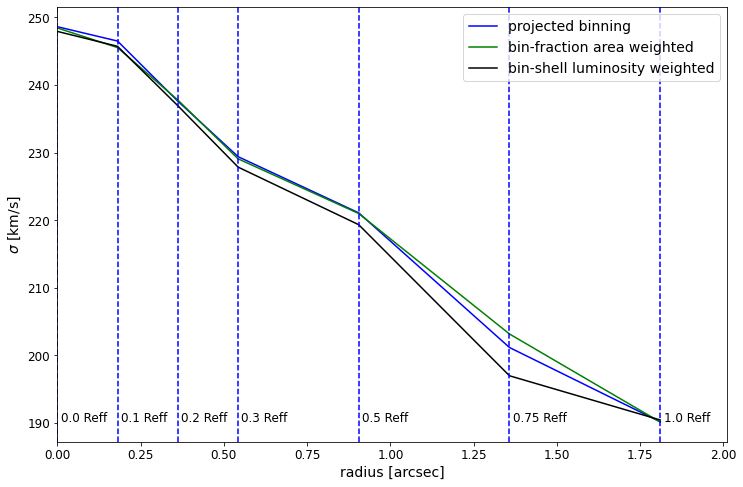

In [303]:
# plot rms velocities
plt.figure(figsize=(12,8))
plt.xlim(0, reff+0.2)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('radius [arcsec]', fontsize=14)
plt.ylabel(r'$\sigma$ [km/s]', fontsize=14)
plt.plot(radial_bins*reff, Vrms_bins, c='b', label='projected binning')
plt.plot(radial_bins*reff, weighted_mean_shell_Vrms, c='g', label='bin-fraction area weighted')
plt.plot(radial_bins*reff, lum_weighted_mean_shell_Vrms, c='k', label='bin-shell luminosity weighted')
plt.legend(fontsize=14)
for bin in radial_bins:
    plt.axvline(bin*reff, c='b', linestyle='--')
    plt.annotate(f'{bin} Reff', (bin*reff+0.01, np.min(Vrms_bins)), fontsize=12 )
